# 02477 Bayesian Machine Learning - Exercise 2

In [1]:
%matplotlib inline
import pylab as plt
import pandas as pd
import jax.numpy as jnp
from jax import random
import seaborn as snb


from scipy.stats import binom as binom_dist
from scipy.stats import norm, bernoulli

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.)
colors = 'brgmc'

# Introduction

The purpose of this exercise is to dive deeper into the basic concepts of probabilistic and Bayesian modelling using **logistic regression** as a case-study. Specifically, we will study:

- the probability distributions involved in logistic regression
- how to approximate the posterior distribution of non-conjugate models using simple grid approximations
- how to make predictions using posterior predictive distributions

We will study these concepts using data from Challenger Space Shuttle disaster.


**Content**

- Part 1: Setting up the logistic regression model
- Part 2: The prior, likelihood and posterior
- Part 3: Making predictions using point estimates
- Part 4: Approximating the posterior using a grid approximation
- Part 5: Propagating uncertainty from parameters to predictions



# Dataset: The Challenger Space Shuttle disaster 

On a cold morning on January 28, 1986 the space shuttle called **Challenger** tragically exploded 73 seconds after its launch, killing all 7 crew members. The explosion was later determined to be caused the failure of two out of six so-called o-ring seals in one of the rocket boosters.
The temperature on the day of the launch was close $0^{\circ} C$, which was record-low. The cold weather made the o-rings stiffen, reducing their ability to seal the critical joints, and hence, causing the tragic accident. O-ring failure had previously been observed on 6 of out the 23 prior launches as plotted below.

In this exercise, you will construct a simple Bayesian logistic regression model for predicting the probability of o-ring failure as a function of temperature.

The dataset $\mathcal{D} = \left\lbrace (t_i, y_i) \right\rbrace_{i=1}^{M}$ consists of $M=23$ observations, where $y_i \in \left[0, 1, \dots 6\right]$ denotes the number of failed o-rings for the $i$'th temperature $t_i$. The number of o-rings for all launches were $N = 6$, and hence, the fraction of failed o-rings for the $i$'th launch is $\frac{y_i}{N} = \frac{y_i}{6}$.

See [Wikipedia](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) for more background information.


First, we will load the data:

In [15]:
# load data from csv file uisng pandas
data = pd.read_csv('./o-ring.csv')
print(len(data))
t = data['temperature'].values
y = data['failed'].values
N = data['count'].values

data.head()

23


temperature  failed  count
0    18.888889       0      6
1    21.111111       1      6
2    20.555556       0      6
3    20.000000       0      6
4    19.444444       0      6

.. and plot it:

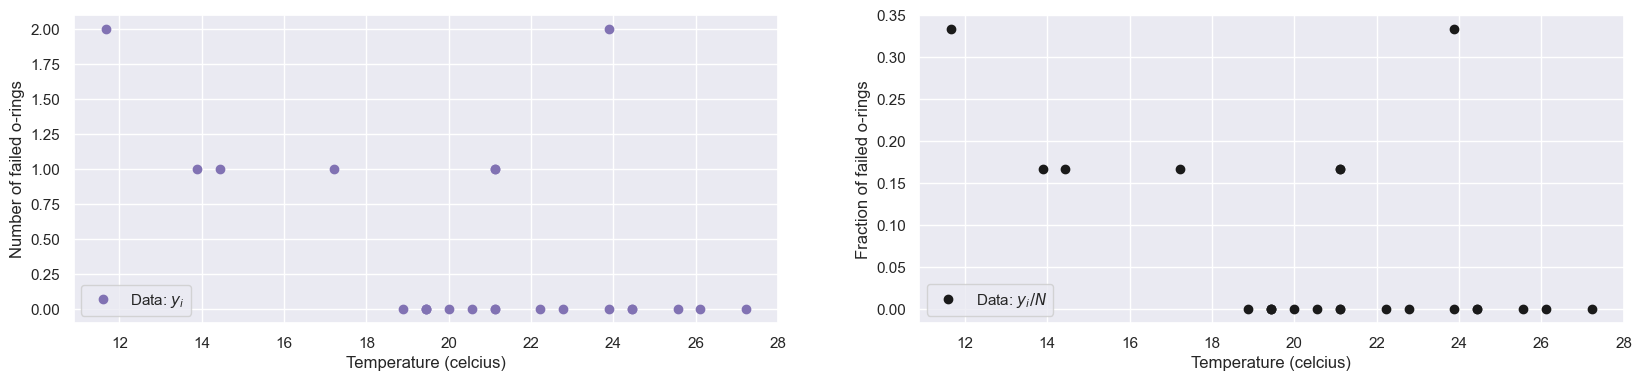

In [16]:
# helper function for plotting data
def plot_data(ax=None, counts=True):
    if counts:
        ax.plot(t, y, 'mo', label='Data: $y_i$')
        ax.set(ylabel='Number of failed o-rings')
    else:
        ax.plot(t, y/N, 'ko', label='Data: $y_i/N$')
        ax.set(ylabel='Fraction of failed o-rings')
    ax.set(xlabel='Temperature (celcius)')
    ax.legend(loc='lower left')

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
plot_data(ax[0])
plot_data(ax[1], counts=False)

Rather than working directly with the temperatures $t_i \in \mathbb{R}$, we will standardize the temperatures to get

$$\begin{align*}
x_i = \frac{t_i - t_{\text{mean}}}{t_{\text{std}}},
\end{align*}$$
where $t_{\text{mean}}$ and $t_{\text{std}}$ are the empirical mean and standard deviation, respectively, of the observed temperatures $\left\lbrace t_i \right\rbrace_{i=1}^M$.

In [17]:
# compute mean and standard deviation of temperatures
tmean, tstd = jnp.mean(t), jnp.std(t)

# standardize temperatures
standardize = lambda t_: (t_ - tmean)/tstd
x = standardize(t)

print(f'Mean temperature: {tmean:.2f}, Standard deviation: {tstd:.2f}')

Mean temperature: 20.87, Standard deviation: 3.83


# Part 1:  Setting up the logistic regression model

### The big picture

Our goal is to use the training data, i.e. the pairs of $\mathbf{x}_i$ and $y_i$, to learn a model such that we can make predictions and reason about the number of failures $y^*$ for a new input point $x^*$. In probabilistic terms, our goal is to compute $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$. That is, the distribution of the number of failures $y^*$ **conditioned on** the observed data $\mathbf{x}, \mathbf{y}$ as well as the new input point $x^*$. In probabilistic machine learning, we generally refer to $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$ as the **posterior predictive distribution**.
Once we computed this distribution, we can use it to reason about $y^*$ and answer questions like:
- What is the expected number of failures?
- What is the most likely number of failures?
- What is the probability that the number of failures is zero?
- What is a 90% interval credibility interval for the number of failures?

Before we can compute $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$, we first need to specify a model.

### Specifying the model

For each temperature $x_i$, we know the number of failed o-ring $y_i = \{0, 1, \dots, 6 \}$ out of the total number of o-rings $N_i = 6$. Hence, the number of failing o-rings $y_i$ for a given temperature $x_i$ can be described by a **Binomial distribution** with $N_i = 6$ and probability $\theta_i \in \left[0, 1\right]$: 

$\begin{align}
y_i|\theta_i \sim \text{Bin}(N_i, \theta_i).
\end{align}
$

This is equivalent to modelling the failure of each individual o-ring as **conditionally independent** Bernoullli trials. Since all observations have $N_i = 6$, we drop the subscript $i$ and simply write $N = 6$ in the following to ease the notation.

Rather than imposing Beta-distributions as prior distributions for each $\theta_i$, we assume $\theta_i$ can be modelled as is a function of the temperature. Specifically, we assume

$\begin{align}
\theta(x) = \sigma(\alpha + \beta x),
\end{align}
$

where $\alpha, \beta \in \mathbb{R}$ are parameters to be estimated and $\sigma: \mathbb{R} \rightarrow \left[0, 1\right]$ is the **logistic sigmoid function**, i.e. $\sigma(x) = (1+\exp(-x))^{-1}$. For later references, we will denote the linear component of the model as $f(x)$, i.e.

$\begin{align}
f(x) = \alpha + \beta x.
\end{align}
$
Note that both $\theta(x)$ and $f(x)$ do indeed depend on $\alpha$ and $\beta$, but we suppress this dependency to ease the notation. The likelihood of the $i$'th data point thus becomes
$
\begin{align}
p(y_i|x_i, \alpha, \beta) = \text{Bin}(y_i|N_i, \theta_i),
\end{align}
$
where we have defined $\theta_i \equiv \theta(x_i) = \sigma(\alpha+\beta x_i)$. Assuming that all observations $\left\lbrace y_i \right\rbrace_{i=1}^M$ are **conditionally independent** given $\theta_i$, the likelihood of the full dataset becomes

$\begin{align}
p(\mathbf{y}|\mathbf{x}, \alpha, \beta) = \prod_{i=1}^M p(y_i|x_i, \alpha, \beta) = \prod_{i=1}^M  \text{Bin}(y_i|N, \theta_i),
\end{align}
$

where $\mathbf{y} = [y_1, y_2, \dots, y_M]$ and $\mathbf{x} = [x_1, x_2, \dots, x_M]$. Our goal is to be able to predict $y^*$ for a new temperature $x^*$.  To do this we write down the *predictive likelihood* for $y^*$, i.e.

$\begin{align}
p(y^*|x^*, \alpha, \beta) = \text{Bin}(y^*|N^*, \theta^*),
\end{align}
$ 

where $\theta^* \equiv \theta(x^*) = \sigma(\alpha + \beta x^*)$. Using the **product rule** and the assumption of conditional independence, we have

$\begin{align}
p(\mathbf{y}, y^*|\mathbf{x}, x^*, \alpha, \beta) = p(\mathbf{y}|\mathbf{x}, \alpha, \beta)p(y^*|x^*, \alpha, \beta) = \underbrace{\prod_{i=1}^M  \text{Bin}(y_i|N, \theta_i)}_{p(\mathbf{y}|\mathbf{x}, \alpha, \beta)} \underbrace{\text{Bin}(y^*|N^*, \theta^*)}_{p(y^*|x^*, \alpha, \beta)}.
\end{align}
$

To complete the Bayesian model, we need to impose a prior distribution on the parameters $\alpha, \beta$. Since we do not have any information about the parameters, we will impose generic Gaussian priors with zero mean:

$\begin{align}
p(\alpha, \beta) &= \mathcal{N}(\alpha|0, \sigma^2_\alpha)\mathcal{N}(\beta|0, \sigma^2_{\beta}) 
\end{align}
$
Taking a logarithm of the priors, we get
$\begin{align}
\log p(\alpha, \beta) = log \mathcal{N}(\alpha|0, \sigma^2_\alpha) + \log \mathcal{N}(\beta|0, \sigma^2_{\beta}) = -\frac{1}{2\sigma^2_\alpha}\alpha^2 - \frac{1}{2\sigma^2_{\beta}}\beta^2 + \text{const}.
\end{align}
$



for $\sigma^2_\alpha, \sigma^2_\beta > 0$. This leads to the following **joint distribution** for $y^*, \mathbf{y}, \alpha,$ and $\beta$:

$\begin{align}
p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*) = p(y^*|x^*, \alpha, \beta)p(\mathbf{y}|\mathbf{x}, \alpha, \beta) p(\alpha, \beta) = \underbrace{\text{Bin}(y^*|N^*, \theta^*)}_{p(y^*|x^*, \alpha, \beta)}\underbrace{\prod_{i=1}^M  \text{Bin}(y_i|N, \theta_i)}_{p(\mathbf{y}|\mathbf{x}, \alpha, \beta)} \underbrace{\mathcal{N}(\alpha|0, \sigma^2_\alpha)\mathcal{N}(\beta|0, \sigma^2_{\beta})}_{p(\alpha, \beta)},
\end{align}
$

where we again used the product rule.

The joint distribution is a central object because it completely determines how all variables (e.g. both data and parametes) interact and thus, it completely specifies our probabilistic model. From the joint distribution, we can derive any related distribution of interest using the rules of probability theory. 

### From the joint distribution to the posterior predictive distribution

Because we observe $\mathbf{y}$, we naturally consider the **conditional distribution** of $y^, \alpha, \beta$ given the observed quantities $\mathbf{y}, \mathbf{x}, x^*$. Using the standard rules for condtional distributions, we get:

$\begin{align}
p(y^*, \alpha, \beta|\mathbf{y}, \mathbf{x}, x^*) = \frac{p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*)}{p(\mathbf{y}|\mathbf{x})}.
\end{align}$

Our primary goal is to compute the **posterior predictive distribution** $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$, i.e. the **marginal distribution** of $y^*$ conditioned on the observed data, i.e. $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$ which can be obtained by marginalizing over $\alpha$ and $\beta$ via the **sum rule**:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \int\int p(y^*, \alpha, \beta|\mathbf{y}, \mathbf{x}, x^*) \text{d} \alpha \text{d}\beta= \int\int \underbrace{p(y^*|x^*, \alpha, \beta)}_{\text{likelihood for }y^*} \underbrace{p(\alpha, \beta|\bm{y}, \bm{x})}_{\text{posterior distribution}} \text{d} \alpha \text{d}\beta,
\end{align}
$
as we derived in the lecture. The last equation shows that we can obtain the posterior predictive distribution by averaging the predictive likelihood wrt. to the posterior distribution. Hence, our first effort will be to get a handle on the posterior distribution of $\alpha$ and $\beta$ conditioned on $\mathbf{y}$.

Before starting the practical implementation, we will practice the terminology and the probabilistic machinery.

**Task 1.1**: Use the **product rule** to write down the joint distribution of $\mathbf{y}, \alpha, $ and $\beta$ given $\mathbf{x}$:

*Hint*: This is meant to be an easy task.



**Task 1.2**: Show that $p(\mathbf{y}, \alpha, \beta|\mathbf{x}) = \sum_{y^*}  p(\mathbf{y}, y^*, \alpha, \beta|\mathbf{x}, x^*)$, where the sum is over all possible outcomes of $y^*$.



**Task 1.3**: Use Bayes' rule to express the posterior $p(\alpha, \beta|\mathbf{y}, \mathbf{x})$ in terms of the prior, likelihood and evidence and argue that the posterior is proportional to the joint distribution $p(\mathbf{y}, \alpha, \beta|\mathbf{x})$.




# Part 2:  The prior, likelihood and posterior

The goal of this part is to implement code for evaluating the prior, likelihood and posterior distribution. Due to a combination of **numerical precision** and **mathematical convenience**, we will implement functions for evaluating the logarithm of these distributions. 
Below you are given an incomplete implementation of the logistic regression model. Your task is to complete the implementation. The code contains a few sanity checks that will help to detect potential bugs and errors in your code.


**Task 2.1**: Complete the implementation of the functions *f, theta, log_prior* and *log_likelihood* below.

*Hints*:
- *For implementing the log prior, the function log_npdf is handy.*
- *When implementing the log likelihood, you can  either use *scipy.stats.binom* (imported as binom_dist) or you can implement the PMF of the binomial distribution from scratch.*
- *Note that for each function the output must have the same shape as the inputs. That is, if you run log_prior(1, 1), it should return a scalar. If you run log_prior(alpha_vec, beta_vec), where alpha_vec and beta_vec are [10 x 1] arrays, then the results should also be a [10 x 1] array*


In [18]:
# sigmoid function: computes the logistic sigmoid of x.
sigmoid = lambda x: 1. / (1 + jnp.exp(-x))

# Logarithm of the Normal probability density function.
# Used for defining priors on the logistic regression parameters.
# Parameters:
#   x : variable (scalar or array)
#   m : mean of the normal distribution
#   v : variance of the normal distribution
# Returns:
#   log density with the same shape as x.
log_npdf = lambda x, m, v: -(x - m)**2 / (2 * v) - 0.5 * jnp.log(2 * jnp.pi * v)

class LogisticRegression(object):

    def __init__(self, x, y, N, sigma2_alpha=1., sigma2_beta=1.):
        # Data: 
        #   x: input features (any shape)
        #   y: outcomes (e.g., counts)
        #   N: number of trials per observation
        self.x = x 
        self.y = y
        self.N = N

        # Hyperparameters:
        #   sigma2_alpha: variance for the Gaussian prior on alpha
        #   sigma2_beta: variance for the Gaussian prior on beta
        self.sigma2_alpha = sigma2_alpha
        self.sigma2_beta = sigma2_beta

    def f(self, x, alpha, beta):
        """
        Compute the linear function f(x) = alpha + beta * x.
        
        Parameters:
            x     : Input data. Shape: arbitrary.
            alpha : Intercept. Scalar or array (broadcastable with x).
            beta  : Slope. Scalar or array (broadcastable with x).
        
        Returns:
            The linear combination computed element-wise.
            Output shape: same as x.
        """
        return alpha + x * beta

    def theta(self, x, alpha, beta):
        """
        Compute the logistic function theta(x) = sigma(f(x)),
        where sigma() is the sigmoid function.
        
        Parameters:
            x     : Input data. Shape: arbitrary.
            alpha : Intercept. Scalar or array (broadcastable with x).
            beta  : Slope. Scalar or array (broadcastable with x).
        
        Returns:
            Predicted probabilities after applying the sigmoid.
            Output shape: same as x.
        """
        return sigmoid(self.f(x, alpha, beta))

    def log_prior(self, alpha, beta):
        """
        Compute the log-prior for parameters alpha and beta.
        The prior assumes independent Gaussian distributions with zero mean.
        
        Parameters:
            alpha : Parameter alpha. Scalar or array.
            beta  : Parameter beta. Scalar or array.
        
        Returns:
            Log prior density. Output shape: same as alpha and beta.
        """
        return log_npdf(alpha, 0, self.sigma2_alpha) + log_npdf(beta, 0, self.sigma2_beta)

    def log_likelihood(self, alpha, beta):
        """
        Compute the log-likelihood of the observed data given parameters.
        Uses the binomial PMF for each observation and sums over data points.
        
        Parameters:
            alpha : Parameter alpha. Scalar or array.
            beta  : Parameter beta. Scalar or array.
        
        Returns:
            Log-likelihood value(s) with shape compatible with alpha.
            If using arrays for alpha and beta, the likelihood is summed over the last axis.
        """
        # Compute theta for given x, alpha, and beta.
        theta = self.theta(self.x, alpha, beta)
        # Compute the log PMF for a Binomial distribution and sum over the last axis;
        # output shape will be broadcastable with the input parameters.
        log_lik = jnp.sum(binom_dist.logpmf(self.y, self.N, theta), axis=-1, keepdims=True)
        return log_lik

    def log_joint(self, alpha, beta):
        """
        Compute the log joint probability: log p(y, alpha, beta | x),
        which is the sum of the log-prior and the log-likelihood.
        
        Parameters:
            alpha : Parameter alpha. Scalar or array.
            beta  : Parameter beta. Scalar or array.
        
        Returns:
            Log joint density, squeezed to remove any singleton dimensions.
            Output shape depends on the shapes of alpha and beta.
        """
        return self.log_prior(alpha, beta).squeeze() + self.log_likelihood(alpha, beta).squeeze()
        
    def theta(self, x, alpha, beta):
        """ implements eq. (2). Output must have the same shape as x """
        
        return sigmoid(self.f(x, alpha, beta))

    def log_prior(self, alpha, beta):
        """ implements log. of eq. (8). Output must have the same shape as alpha and beta """
        return log_npdf(alpha, 0, self.sigma2_alpha) + log_npdf(beta, 0, self.sigma2_beta)

    def log_likelihood(self, alpha, beta):
        """ implements log. of eq. (5). Output must have the same shape as alpha and beta """
        theta = self.theta(x, alpha, beta)
        log_lik = jnp.sum(binom_dist.logpmf(self.y, self.N, theta), axis=-1, keepdims=True)
        return log_lik

    def log_joint(self, alpha, beta):
        return self.log_prior(alpha, beta).squeeze() + self.log_likelihood(alpha, beta).squeeze()
    
# instantiate model
model = LogisticRegression(x, y, N)

# some sanity checks to help verify your implementation and make it compatible with the rest of the exercise
#assert jnp.allclose(model.theta(x=2, alpha=2, beta=-0.5), 0.7310585786300049), "The value of output of the theta-function was different than expected. Please check your code."
#assert jnp.allclose(model.log_prior(1., 1.), -2.8378770664093453), "The value of the output of the log_prior function was different than expected. Please check your code."
#assert jnp.allclose(model.log_likelihood(-1.,2.), -95.18926297085957), "The value of the output of the log_likelihood function was different than expected. Please check your code."
#
#assert model.theta(jnp.linspace(-3, 3, 10), 1, 1).shape == (10,), "The shape of the output of the theta-function was different than expected. Please check your code."
#assert model.log_prior(jnp.linspace(-3, 3, 10), jnp.linspace(-3, 3, 10)).shape == (10,), "The shape of the output of the log_prior-function was different than expected. Please check your code."
#assert model.log_likelihood(jnp.linspace(-3, 3, 10)[:, None], jnp.linspace(-3, 3, 10)[:, None]).shape == (10, 1),  "The shape of the output of the log_likelihood-function was different than expected. Please check your code."


If the model implementation above is correct, then the code below should produce contour plots of the prior, likelihood and posterior. We also compute and plot the MLE and MAP estimators for the model. Because this is a 2D problem, we can simply obtain the MLE/MAP estimators by maximizing over the set of grid values. However, this becomes infeasible in higher dimensions, where gradient-based optimization is used instead.

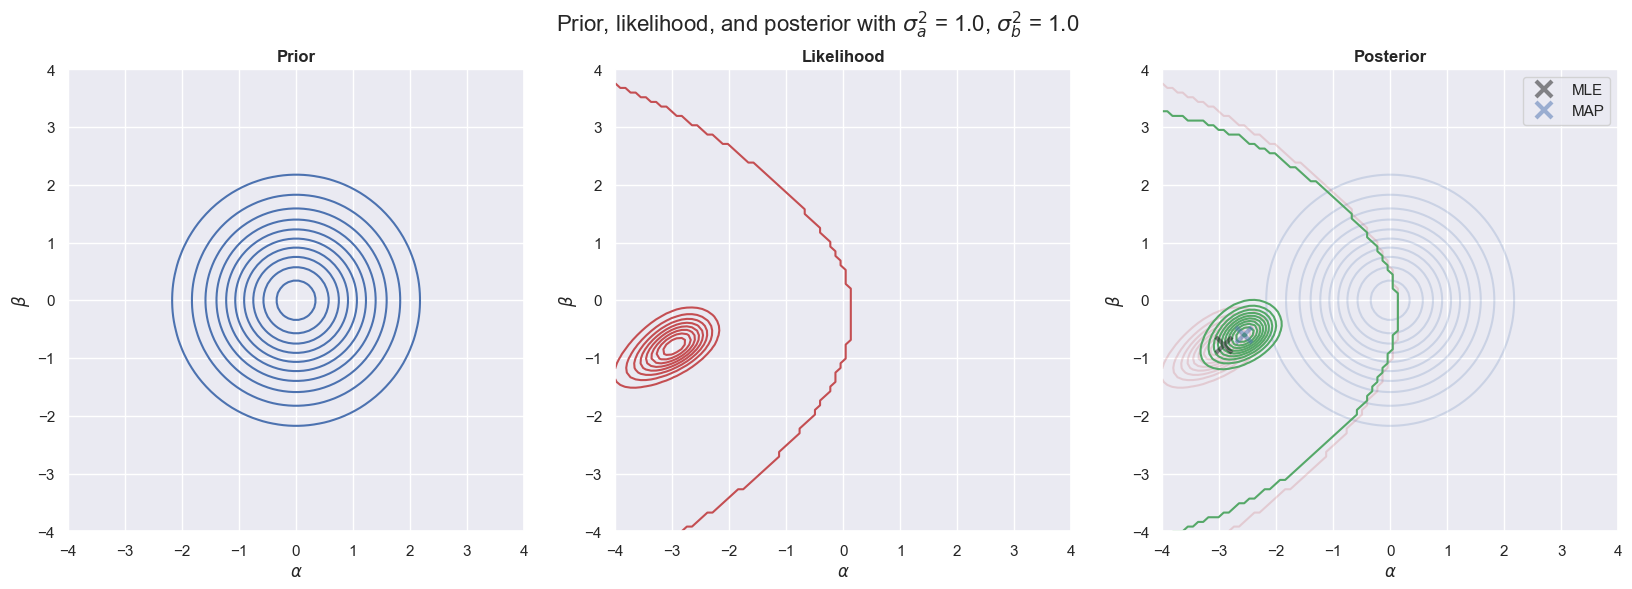

In [19]:
class Grid2D(object):
    """Helper class for evaluating a function on a 2D grid defined by (alpha, beta)."""

    def __init__(self, alphas, betas, func, name="Grid2D"):
        # Store the grid values and the function to evaluate
        self.alphas = alphas
        self.betas = betas
        # Determine the grid dimensions (number of points along each axis)
        self.grid_size = (len(self.alphas), len(self.betas))
        # Create a meshgrid for alpha and beta using 'ij' indexing so that the first dimension
        # corresponds to alpha and the second to beta.
        self.alpha_grid, self.beta_grid = jnp.meshgrid(alphas, betas, indexing='ij')
        # function can be something like model.log_prior, model.log_likelihood, model.log_joint
        # we cal self.fun on ever point of the grid. For example, func might be 
        # model.log_prior, so it gets evaluated on every (alpha, beta) pair in the grid
        # The result is stored in self.values 
        self.func = func
        self.name = name
        
        # Compute the function values on the grid.
        # By adding a new axis at the end (with [:, :, None]) we prepare the alpha and beta arrays
        # for broadcasting with the function output. The squeeze() method removes any extra dimensions.
        self.values = self.func(self.alpha_grid[:, :, None], self.beta_grid[:, :, None]).squeeze()

    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        """
        Plot contour lines for the function evaluated on the grid.
        (Often we pass f=jnp.exp to turn log-values into probabilities.)
        
        Parameters:
            ax            : Matplotlib axis to plot on.
            color         : Color of the contour lines.
            num_contours  : Number of contour levels.
            f             : A transformation applied to self.values before plotting (e.g., exponentiation).
            alpha         : Transparency of contour lines.
            title         : Optional title for the plot.
        """
        # Plot contours using the transformed values.
        # Note: .T is used to transpose the values so that they match the grid orientation.
        ax.contour(self.alphas, self.betas, f(self.values).T, num_contours, colors=color, alpha=alpha)
        # Label the axes
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        # Set the title of the plot to the grid's name
        ax.set_title(self.name, fontweight='bold')

    @property
    def argmax(self):
        """
        Return the alpha and beta values corresponding to the maximum value in the grid.
        
        This property identifies the grid point with the highest evaluated function value.
        """
        # Find the index of the maximum value in the flattened grid
        idx = jnp.argmax(self.values)
        # Convert the flat index to 2D indices corresponding to the grid_shape
        # jnp.unravel_index converts a single index back to (row, column) indices so we 
        # can get the corresponding 𝛼 and β from the lists.
        alpha_idx, beta_idx = jnp.unravel_index(idx, self.grid_size)
        # Return the corresponding alpha and beta values from the grid arrays
        return self.alphas[alpha_idx], self.betas[beta_idx]

SIGMA2_ALPHA = 1.0
SIGMA2_BETA = 1.0



# Define grid points for alpha and beta.
# The numbers of grid points are chosen differently to aid debugging.
num_alpha, num_beta = 90, 100
alphas = jnp.linspace(-4, 4, num_alpha)
betas = jnp.linspace(-4, 4, num_beta)

# Instantiate the logistic regression model with the given data and priors.
model = LogisticRegression(x, y, N, sigma2_alpha=SIGMA2_ALPHA, sigma2_beta=SIGMA2_BETA)

# Evaluate log prior, log likelihood, and log joint (posterior) over the (alpha, beta)-grid.
log_prior_grid = Grid2D(alphas, betas, model.log_prior, 'Prior')
log_lik_grid = Grid2D(alphas, betas, model.log_likelihood, 'Likelihood')
log_joint_grid = Grid2D(alphas, betas, model.log_joint, 'Posterior')

# Create a figure with 3 subplots for Prior, Likelihood, and Posterior contours.
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Overlay the prior (blue) and likelihood (red) contours on the Posterior plot (third subplot)
log_prior_grid.plot_contours(ax[2], f=jnp.exp, color='b', alpha=0.2)
log_lik_grid.plot_contours(ax[2], f=jnp.exp, color='r', alpha=0.2)

# Plot individual contour plots for prior, likelihood, and posterior on separate subplots.
for idx_plot, grid in enumerate([log_prior_grid, log_lik_grid, log_joint_grid]):
    grid.plot_contours(ax[idx_plot], f=jnp.exp, color=colors[idx_plot])

# Compute the MLE estimator from the likelihood grid.
alpha_MLE, beta_MLE = log_lik_grid.argmax
# Compute the MAP estimator from the posterior grid.
alpha_MAP, beta_MAP = log_joint_grid.argmax

# Mark the MLE (red x) and MAP (green x) on the Posterior plot.
plt.suptitle(rf"Prior, likelihood, and posterior with $\sigma^2_a$ = {model.sigma2_alpha}, $\sigma^2_b$ = {model.sigma2_beta}", fontsize=16)
ax[2].plot(alpha_MLE, beta_MLE, 'kx', label='MLE', markersize=12, markeredgewidth=3, alpha=0.5)
ax[2].plot(alpha_MAP, beta_MAP, 'bx', label='MAP', markersize=12, markeredgewidth=3, alpha=0.5)
ax[2].legend();
    


**Task 2.2**: When plotting the contours of the posterior distribution, we actually evaluate the joint distribution and not the posterior distribution . Why is this okay when making contour plots?


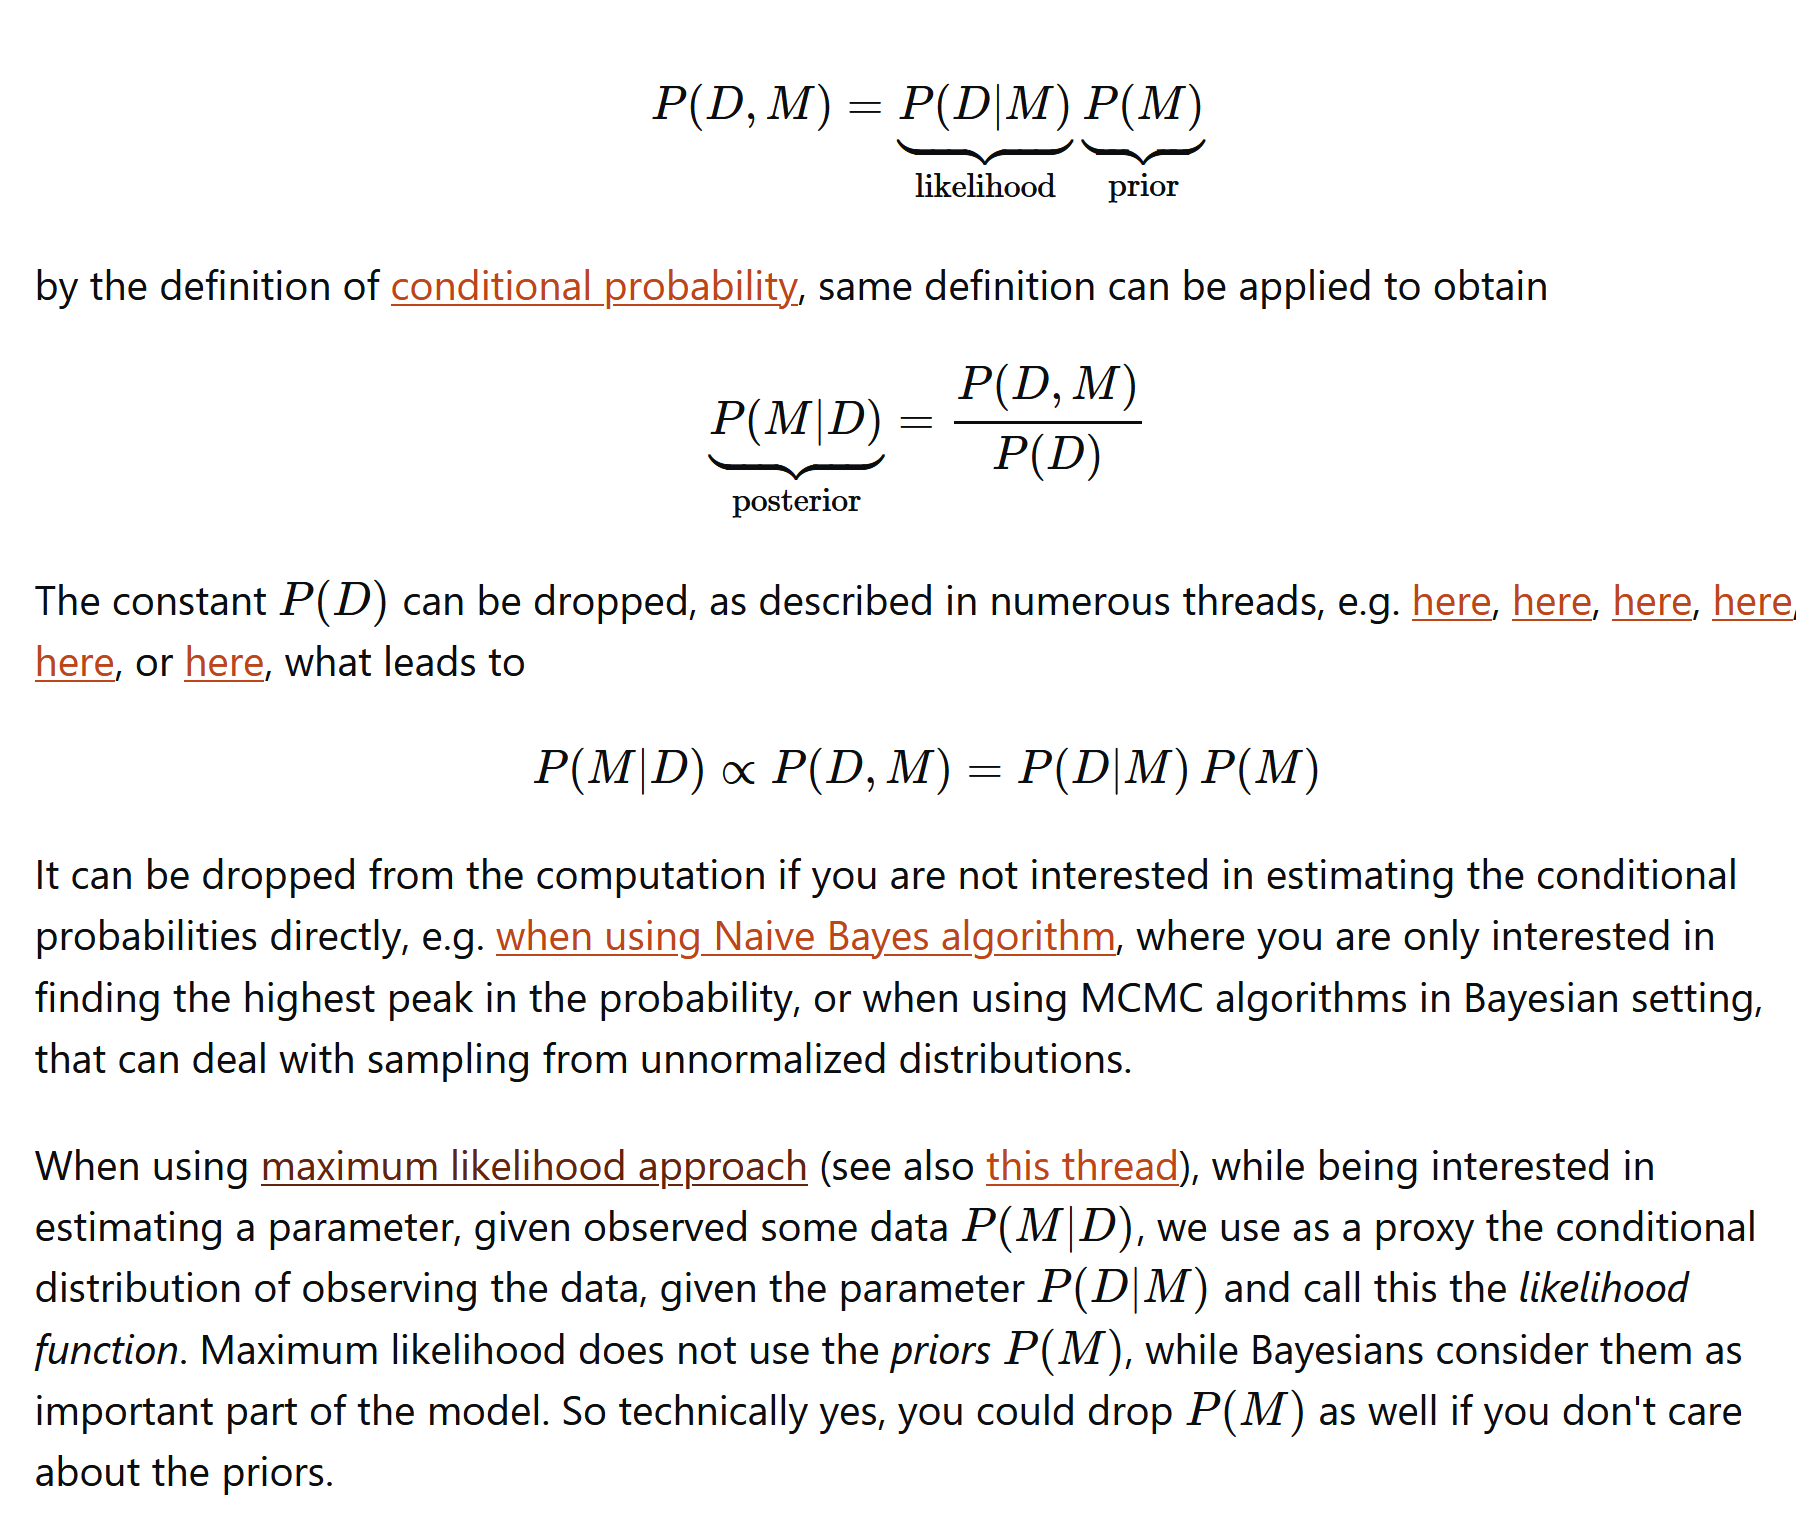







- We oberve that the **Prior** us inuform, centered at zero (and is Circular Gaussian)
- The **Likelihood** is a highly skewed around (-3, -1) 
- The **posterior** combines the information of prior and likelihood 
    - We see that the posterior is a combination of the prior and likelihood.
    - The prior pulls the likelihood towards 0, but the likelihood pulls the posterior towards the region where the likelihood is large.
- MLE is where the likelihood function is maximized, ignoring the prior. 
- MAP is where is where the posterior is maximized, taking the prior into account.
    - Since the prior is uniform, MAP is closer to the likelihood than the MLE, but still influenced by the prior.

**Task 2.3**: Use the code above to experiment and investigate the relationship between the prior, likelihood and posterior. What happens if you change the prior variances of $\alpha, \beta$? E.g. $\sigma^2_{\alpha} = \sigma^2_{\beta} = 10$, $\sigma^2_{\alpha} = \sigma^2_{\beta} = 100$, $\sigma^2_{\alpha} = \sigma^2_{\beta} = 0.1$? What happens if $\sigma^2_\alpha = 1$ and $\sigma^2_{\beta} = 10$?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*

### $\sigma^2_{alpha} = 1.0, \sigma^2_{beta} = 1.0$

- We oberve that the **Prior** us inuform, centered at zero (and is Circular Gaussian)
- The **Likelihood** is a highly skewed around (-3, -1) 
- The **posterior** combines the information of prior and likelihood 
    - We see that the posterior is a combination of the prior and likelihood.
    - The prior pulls the likelihood towards 0, but the likelihood pulls the posterior towards the region where the likelihood is large.
- MLE is where the likelihood function is maximized, ignoring the prior. 
- MAP is where is where the posterior is maximized, taking the prior into account.
    - Since the prior is uniform, MAP is closer to the likelihood than the MLE, but still influenced by the prior.

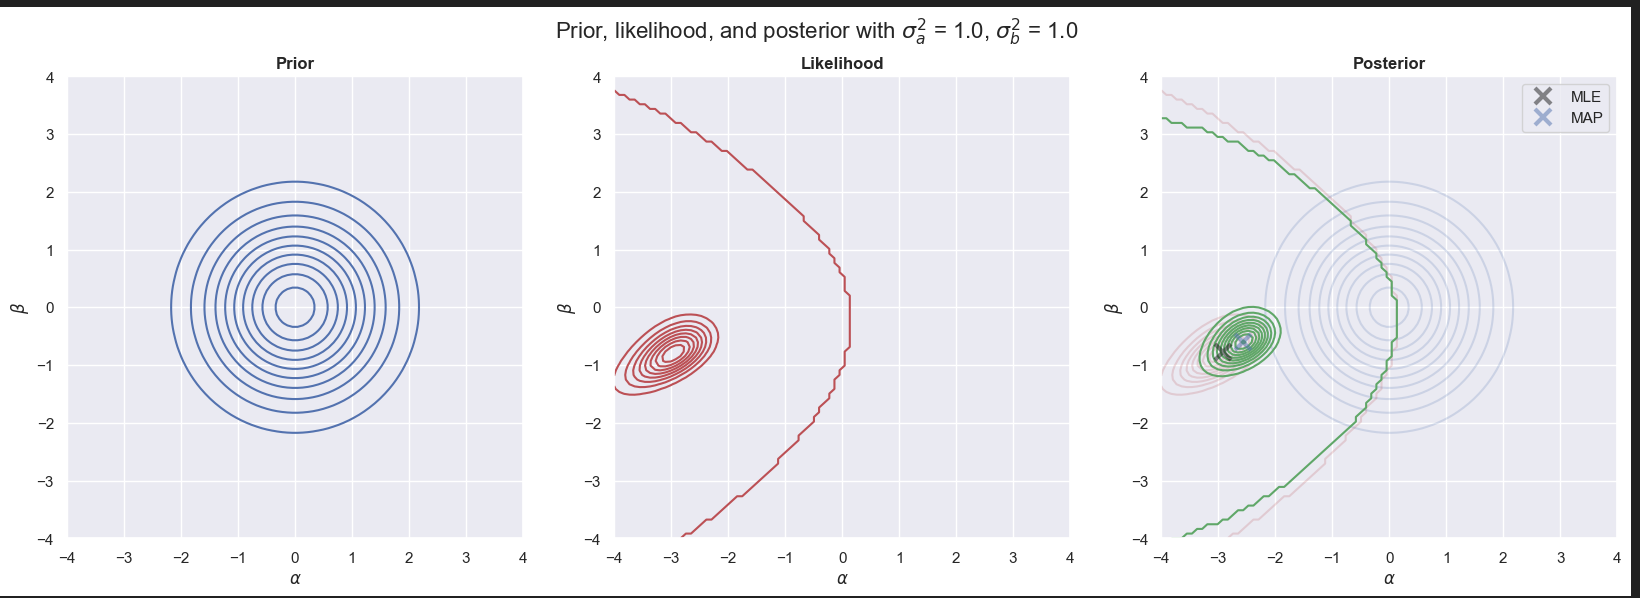
______
### $\sigma^2_{alpha} = 10.0, \sigma^2_{beta} = 10.0$
- The **prior** is now more spread out. 
    - This indicates tha the prior is now less informative, and the likelihood will have a larger impact on the posterior.
- The **likelihood** is the same as before (as it is determined by the data).
- The **posterior** is now more influenced by the likelihood than the prior, the prior is very weak and the posterior is 
nearly same as the likelihood. 
- The **MAP** is now closer to the MLE

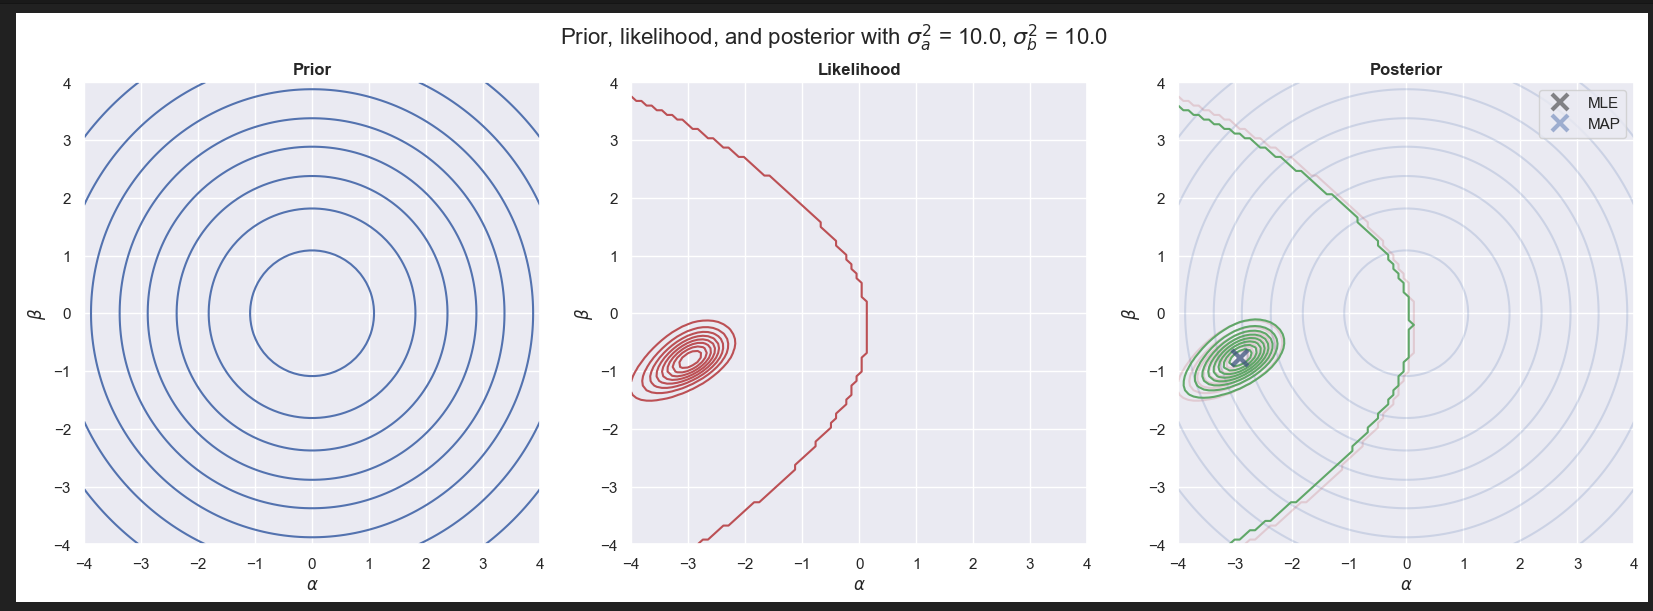

______

### $\sigma^2_{alpha} = 100., \sigma^2_{beta} = 100.0$
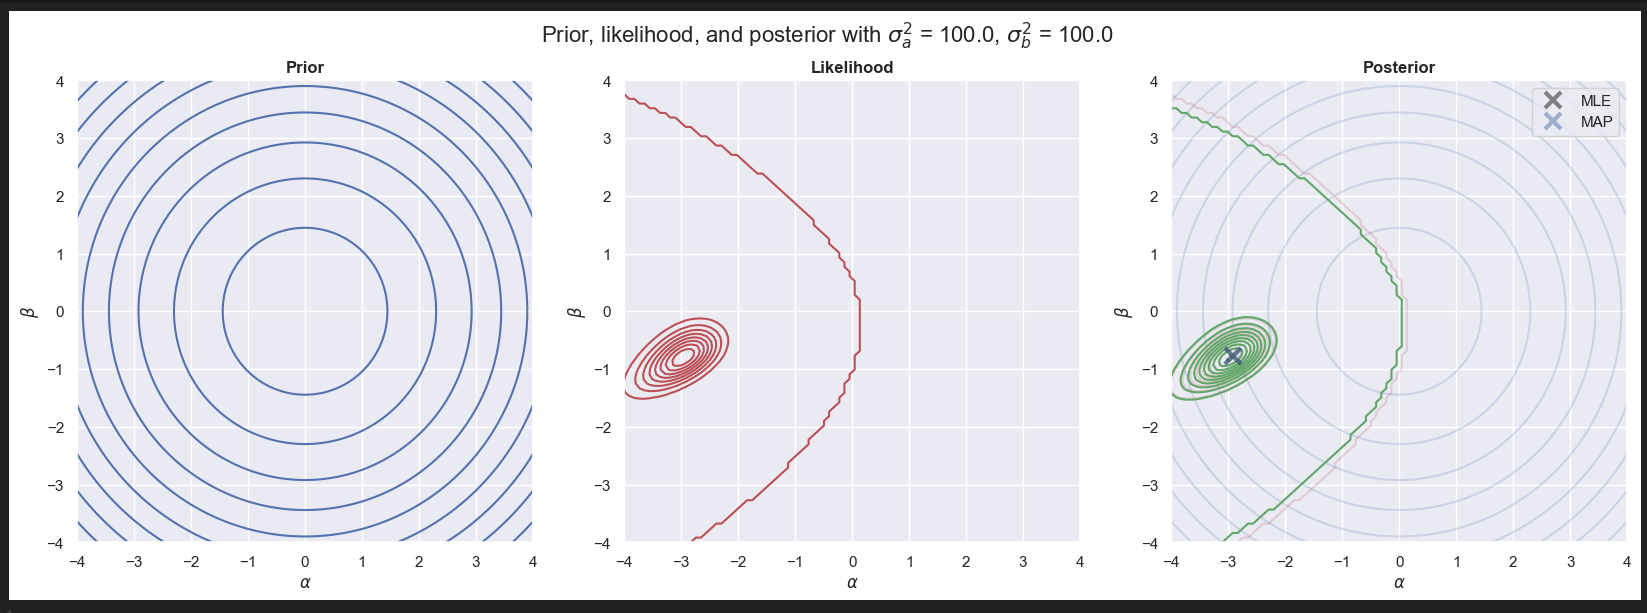
This is just more extreme version of the previous case. The prior is even weaker, and the posterior is nearly the same as the likelihood. The MAP is nearly the same as the MLE.
______
### $\sigma^2_{alpha} = 0.1, \sigma^2_{beta} = 0.1$
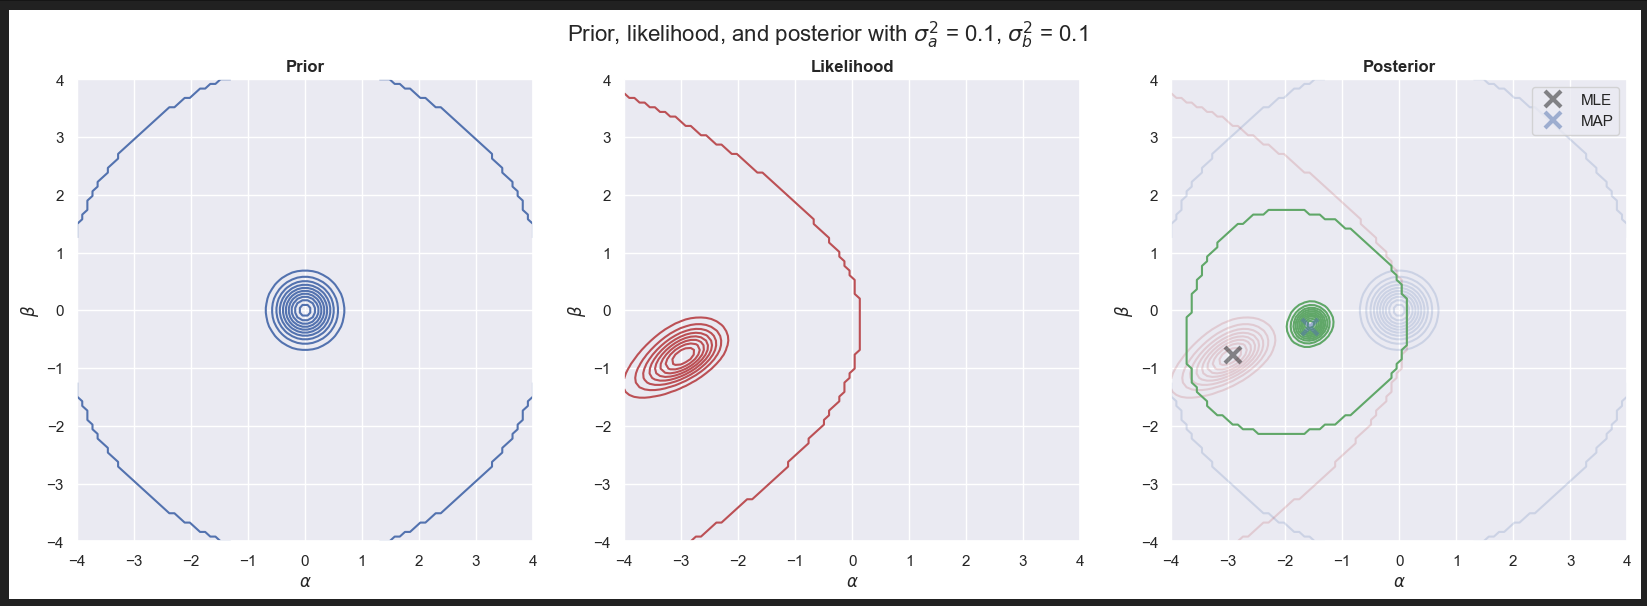
- The **prior** is now more concentrated around zero. 
    - This indicates that the prior is now more informative, and the prior will have a larger impact on the posterior.
- The **likelihood** is the same as before (as it is determined by the data). Very different from the prior.
- The **posterior** is now more influenced by the prior than the likelihood, the prior is very strong and the posterior is therefore pulled towards the prior.
- The **MAP** is now closer to the prior mean than the MLE, it is balanced between the prior and the likelihood.
- The **MLE** is where the likelihood function is maximized, ignoring the prior.
______

### $\sigma^2_{alpha} = 1.0, \sigma^2_{beta} = 10.0$
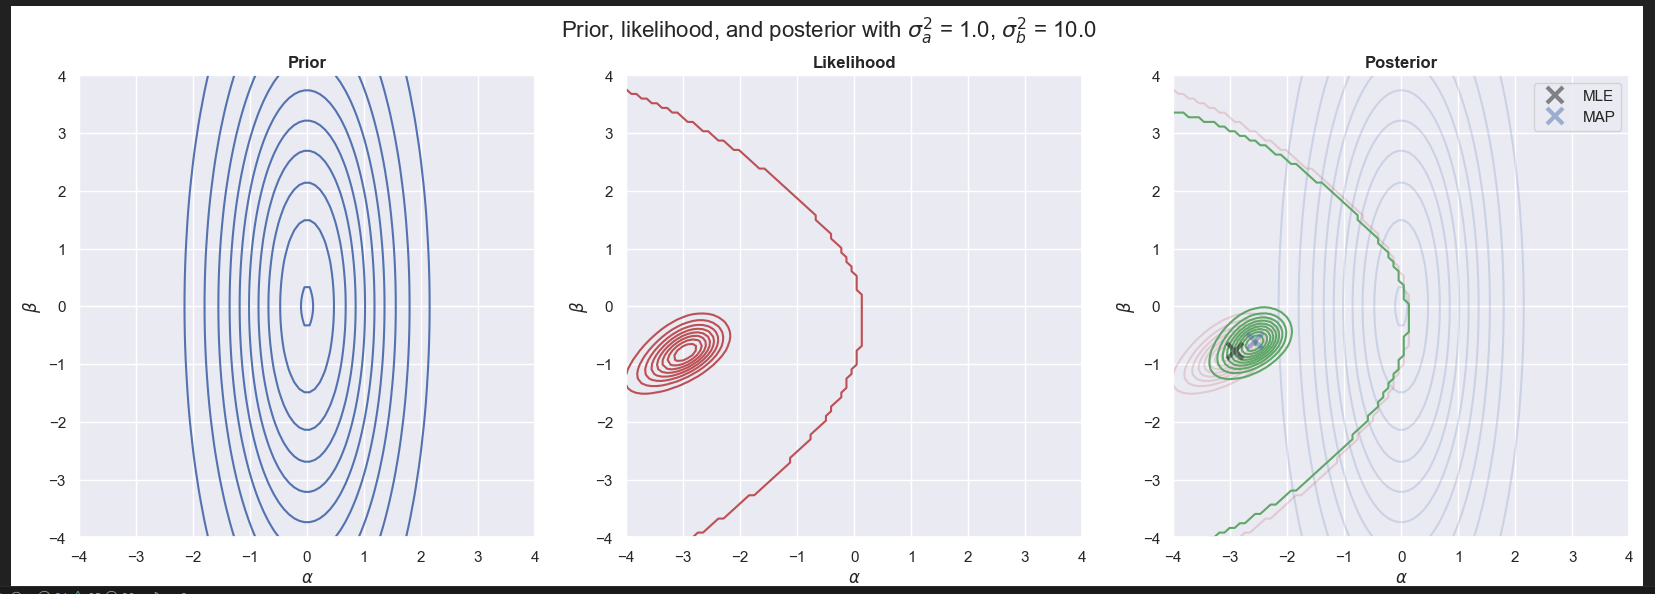
- The prior is now anisotropic  (different variance for alpha and beta). The prior is more informative for beta than for alpha. 
    - The prior is more confident in in the value of alpha than beta.
- The likelihood is the same as before (as it is determined by the data). Very different from the prior.
- The posterior is now a balance between the stronger prior on alpha and the weaker prior on beta.
    - Since the prior is more **restrictive along $\alpha$, the posterior is shifted closer to 0 along the $\alpha$ axis.
    - Since the prior is **weaker along $\beta$**, the posterior is closer to the likelihood along the $\beta$ axis.

______

### $\sigma^2_{alpha} = 10.0, \sigma^2_{beta} = 1.0$
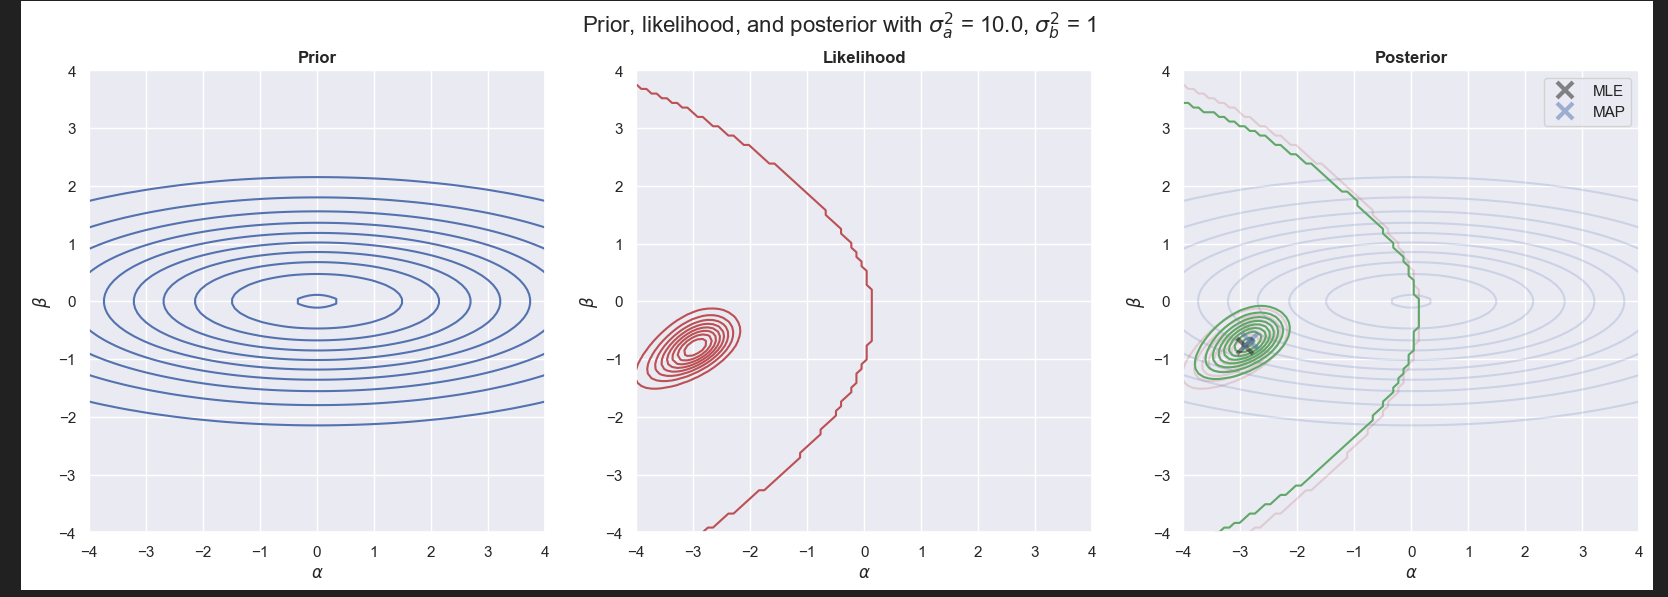
- The **prior** is stretches along the $\alpha$ axis, indicating that we are less confident in the value of $\alpha$ than $\beta$.
    - However, it is tighter along the $\beta$ axis, indicating that we are more confident in the value of $\beta$, being closer to 0.
- The **likelihood** is the same as before (as it is determined by the data). Very different from the prior.
- The **posterior** is now a balance between the stronger prior on beta and the weaker prior on alpha.
    - Since the prior is more **restrictive along $\beta$, the posterior is shifted closer to 0 along the $\beta$ axis.
    - Since the prior is **weaker along $\alpha$**, the posterior is closer to the likelihood along the $\alpha$ axis.





**Task 2.4**: What happens to the MLE and MAP estimators when you change the variances of the prior?

**MLE** 
- *Definition*: The MLE is the parameter value that maximizes the likelihood function, which depends on the observed data.
- *Effect of changing the prior variance: 
    - The MLE does not change when the prior variance is modified, because it is independent of the prior.
    - It is always located at the maximum of the likelihood function.

**MAP**
- *Definition*: The MAP is the parameter value that maximizes the posterior distribution, which is the product of the likelihood and the prior.
- Effect of changing the prior variance: 
    - *Low prior variance (strong prior)*
        - The MAP is closer to the prior mean than the MLE.
        - The prior has a strong influence on the posterior, pulling the MAP towards the prior mean.
    - *High prior variance (weak prior)*
        - The MAP is closer to the MLE.
        - The prior has a weak influence on the posterior, and the MAP is closer to the MLE.


Summary table of the effect of changing the prior variance on the posterior distribution and the MLE/MAP estimators:

| Prior Variance | Posterior Distribution | MLE | MAP |
|----------------|------------------------|-----|-----|
| Low            | Prior has strong influence on posterior | MAP is closer to prior mean | MAP is closer to prior mean |
| Moderate       | Prior has moderate influence on posterior | MAP is closer to prior mean | MAP is closer to prior mean |
| High           | Prior has weak influence on posterior | MAP is closer to MLE | MAP is closer to MLE |




**Task 2.5**: What happens to the prior, likelihood and posterior if you only use a subset of the data? Use the code above to experiment and investigate what happens, e.g. use the first 10 data instead of the full $M = 23$ datapoints.

### $\sigma^2_{alpha} = 1.0, \sigma^2_{beta} = 1.0$
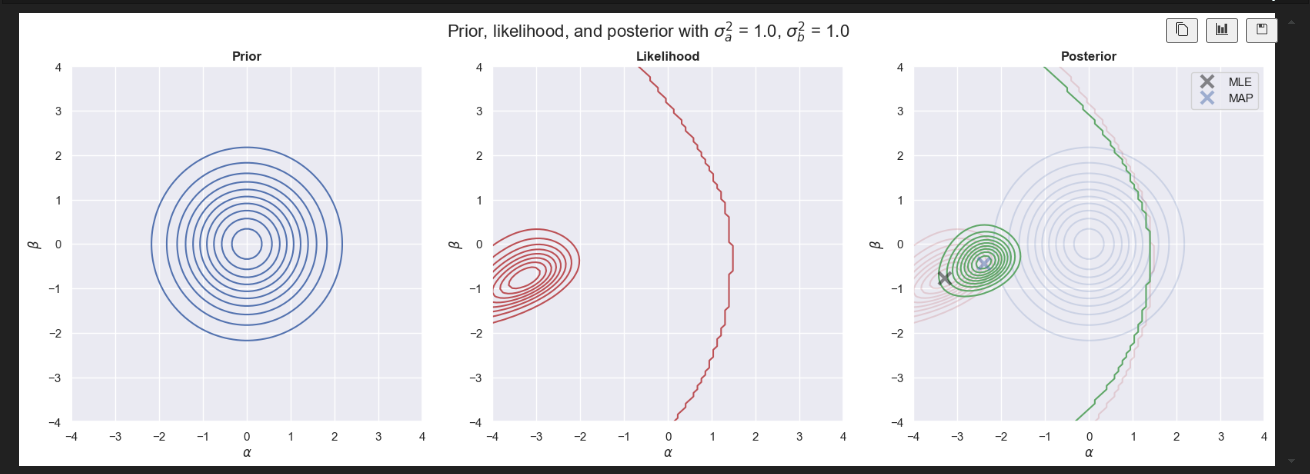

- Prior is uniform, centered at zero. (More or less the same as before in 2.3)
- Likelihood is less concetrated as we have less data, the shape is more wider, which suggests that we are less certain about the likelihood.
- Posterior is a combination of the prior and likelihood, but the prior has a stronger influence on the posterior, since the likelihood is less certain.
- MLE is where the likelihood function is maximized, ignoring the prior.
- MAP is closer to the prior mean compared to the full-data case.
    - Since the likelihood is weaker, the prior’s effect is stronger.
    - If you further reduce the dataset, MAP will continue to shift toward (0,0).
_____
### $\sigma^2_{alpha} = 10.0, \sigma^2_{beta} = 10.0$
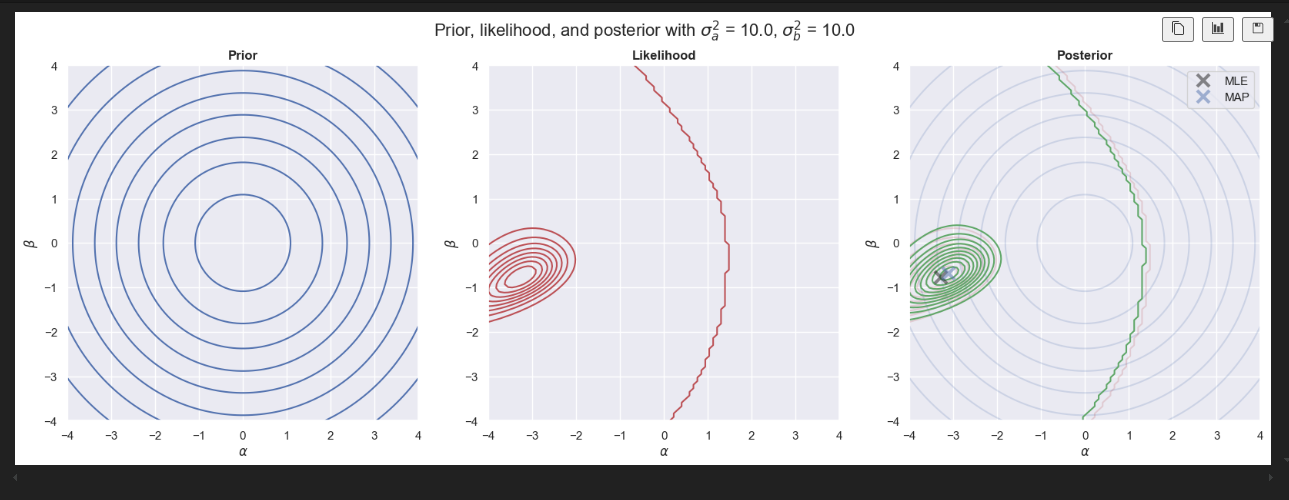
- Prior is more spread out, indicating that we are less certain about the prior.
- Likelihood is less concetrated as we have less data, the shape is more wider, which suggests that we are less certain about the likelihood.
- Posterior is very uncertain, as we have very weak likelihood. 
    - However, since the prior is also weak, it does not significantly pull the posterior toward (0,0).
    - The posterior remains close to the likelihood function, meaning MAP ≈ MLE, but with slightly more smoothing due to the prior.
MAP is very close to MLE, because: The prior is weak ( $\sigma^2 = 10$), so it does not shift the estimate much.
The likelihood function is weak (due to fewer data points), so both estimates have higher uncertainty.
______
### $\sigma^2_{alpha} = 0.1, \sigma^2_{beta} = 0.1$
- Prior is more concentrated around zero, indicating that we are more certain about the prior.
- Likelihood is less concetrated as we have less data, the shape is more wider, which suggests that we are less certain about the likelihood.
- Posterior is a combination of the prior and likelihood, but the prior has a stronger influence on the posterior, since the likelihood is less certain.
    - We can observe that the posterior no longer follows the likelihood, but is strongly influenced by the prior.

- MLE is where the likelihood function is maximized, ignoring the prior.
- MAP is closer to the prior mean compared to the full-data case.
    - Since the likelihood is weaker, the prior’s effect is stronger.
    - If you further reduce the dataset, MAP will continue to shift toward (0,0).

____
### $\sigma^2_{alpha} = 1.0, \sigma^2_{beta} = 10.0$
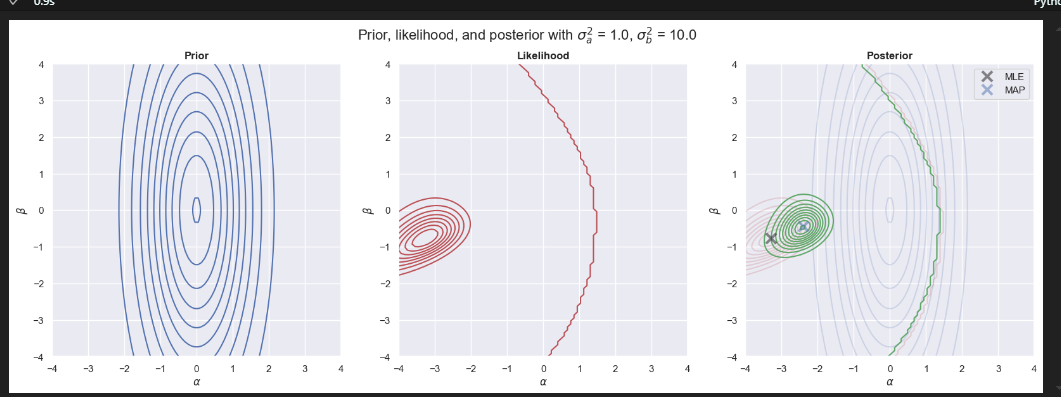
- Very similar as before
-
### $\sigma^2_{alpha} = 10.0, \sigma^2_{beta} = 1.0$
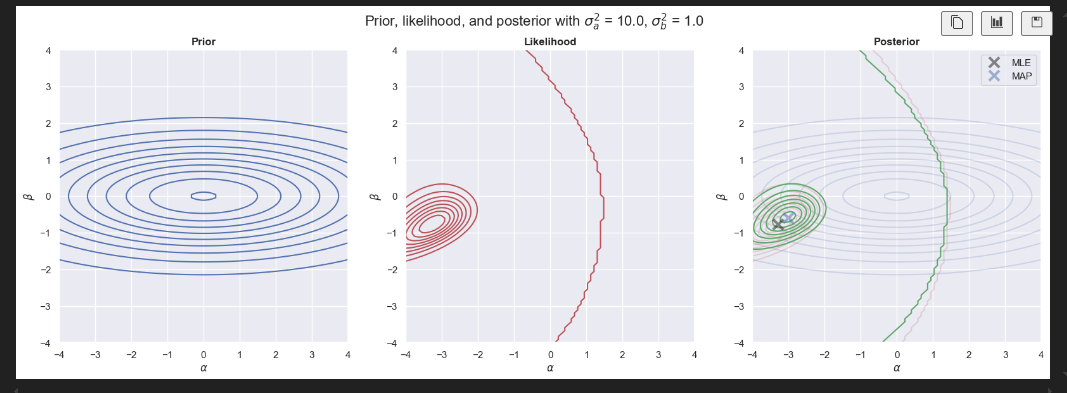
- Very similar as before

**Task 2.6**: Use the plots to roughly estimate the prior and posterior probability of the event $\beta < 0 $.





# Part 3:  Making predictions using point estimates

Our model for the probability of failure for each individual o-ring is given by

$$\begin{align*}
\theta(x) = \sigma(\alpha + \beta x),
\end{align*}
$$

where $\alpha, \beta \in \mathbb{R}$ are unknown parameters. $\alpha$ is the intercept (how prone the system is to failure regardless of temperature) and $\beta$ is the slope (how the probability of failure changes with temperature).

Since we do not know the values of the parameters, we can **estimate** them from the data in several ways. The simplest way is via the maximum likelihood estimator (MLE). (MLE tells us how "plausible" is to see the observed data $y$ (failures vs non-failures) given specific values for $\alpha, \beta$. Furthermore, **MLE** tries to find the single pair ($\alpha, \beta$), that makes the observed data most likely) That is, picking the **point**  that maximizes the likelihood of the data:

$$\begin{align*}
\hat{\alpha}_{\text{MLE}}, \hat{\beta}_{\text{MLE}} = \arg\max_{\alpha, \beta \in \mathbb{R}} p(\mathbf{y}|\mathbf{x}, \alpha, \beta).
\end{align*}
$$

In practice, we most often due this using gradient-based optimization. However, in this exercise, we will simply pick the parameters values that maximizes the likelihood function on the grid, which works well for 2D problems. Instead of using the MLE, we can also use the Maximum a posteriori (MAP) estimator. That is, picking the **point** that maximizes the posterior distribution:
$$\begin{align*}
p(\alpha, \beta | \mathbf{y}, \mathbf{x}) = \frac{p(\mathbf{y}|\mathbf{x}, \alpha, \beta)p(\alpha, \beta)}{p(\mathbf{y}|\mathbf{x})}.
\end{align*}
$$

$$\begin{align*}
\hat{\alpha}_{\text{MAP}}, \hat{\beta}_{\text{MAP}} = \arg\max_{\alpha, \beta} p(\alpha, \beta|\mathbf{y},\mathbf{x}).
\end{align*}
$$





After obtaining an estimate of the parameters, we can use a **plugin approximation** for $\theta(x)$ by simply inserting the **point estimate** (e.g. MLE or MAP) for $\alpha$ and $\beta$:
$$\begin{align*}
\hat{\theta}(x) = \sigma(\hat{\alpha} + \hat{\beta} x),
\end{align*}
$$

and then use $\hat{\theta}$ for making predictions.


**Task 3.1**: Compute and plot the predicted probability $\hat{\theta}(x)$ for $x$ corresponding to temperatures $t \in \left[-10, 40\right]$ for both MLE and MAP estimators.


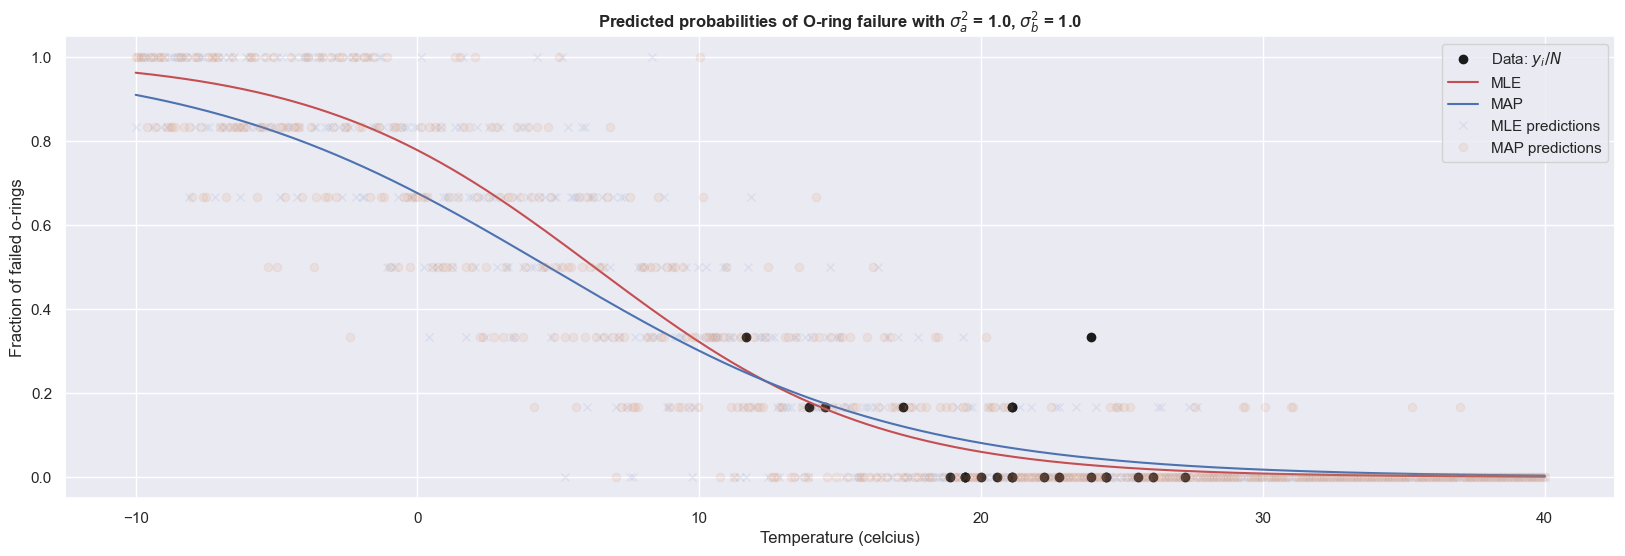

In [31]:
# Generate 500 temperature points from -10 to 40 degrees Celsius for prediction
temp_pred = jnp.linspace(-10, 40, 500)

# Standardize the temperature predictions using the already defined standardization (with tmean and tstd)
x_pred = standardize(temp_pred)

# Set the number of trials per prediction (e.g., number of o-rings tested)
N_pred = 6

# Predict probabilities (theta) using the MAP parameter estimates
theta_MAP = model.theta(x_pred, alpha_MAP, beta_MAP)
#print(theta_MAP)

# Predict probabilities (theta) using the MLE parameter estimates
theta_MLE = model.theta(x_pred, alpha_MLE, beta_MLE)
#print(theta_MLE)

# Simulate binomial outcomes based on the predicted probabilities and number of trials
y_pred_MAP = binom_dist.rvs(N_pred, theta_MAP)
y_pred_MLE = binom_dist.rvs(N_pred, theta_MLE)

# Create a figure for plotting predictions
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

# Plot the observed data (using a helper function 'plot_data', counts set to False for probability scale)
plot_data(ax, counts=False)

# Plot the continuous prediction from MLE (in red) on the temperature scale
ax.plot(temp_pred, theta_MLE, 'r-', label='MLE')

# Set the title for the plot
ax.set_title(rf'Predicted probabilities of O-ring failure with $\sigma^2_a$ = {model.sigma2_alpha}, $\sigma^2_b$ = {model.sigma2_beta}', fontweight='bold')

# Plot the continuous prediction from MAP (in blue)
ax.plot(temp_pred, theta_MAP, 'b-', label='MAP')

# Overlay individual simulated predictions for MLE and MAP (normalized by N_pred)
ax.plot(temp_pred, y_pred_MLE / N_pred, 'x', label='MLE predictions', alpha=0.1)
ax.plot(temp_pred, y_pred_MAP / N_pred, 'o', label='MAP predictions', alpha=0.1)

# Display the legend on the plot
ax.legend()


# Part 4:  Approximating the posterior using a grid approximation

Rather than using point estimates, we will now turn to full Bayesian inference to be able to properly reason above the uncertainty of both parameters and predictions. In contrast to the Beta-binomial model, the logistic regression model is **not a conjugate model**, which means we cannot compute the posterior distribution $p(\alpha, \beta|\mathbf{y}, \mathbf{x})$ analytically. Instead, we will use a very simple **grid approximation** $q(\alpha, \beta)$ to represent the posterior distribution:

$$\begin{align*}
p(\alpha, \beta|\mathbf{y}, \mathbf{x}) \approx q(\alpha, \beta).
\end{align*}
$$

To construct the grid approximation $q(\alpha, \beta)$, we need three steps:

1) **Define grid**: First we need to the define grid for $(\alpha, \beta)$. Typically, we choose an appropriate discrete set of values for $\alpha$ and $\beta$ individually, i.e. $\left\lbrace \alpha_i \right\rbrace_{i=1}^I$ and $\left\lbrace \beta_i \right\rbrace_{j=1}^J$, and then take the $(\alpha, \beta)$-grid to be the Cartesian product.

2) **Evaluation:** Next, we need to evaluate the function $p(\alpha, \beta| \mathbf{y, x})$ on each point in the $(\alpha, \beta)$-grid. Importantly, here we only need to evaluate the posterior **up to a normalization constant**, and hence, **we can evaluate the joint distribution instead of the posterior**. Moreover, for numerical reasons, we often evaluate the **logarithm of the joint distribution**.

3) **Normalization**: To ensure that our approximation is a valid distribution, we need to make it sum to $1$. To achieve this, we compute the sum of $p(\mathbf{y}, \alpha, \beta| \mathbf{x})$ across all grid points to approximate the normalization constant $Z$.

That is, 
$$\begin{align*}
q(\alpha_i, \beta_j) = \frac{1}{Z}p(\bm{y}, \alpha_i, \beta_j| \mathbf{x}) = \frac{1}{Z}\tilde{\pi}_{ij} = \pi_{ij}, 
\end{align*}
$$
where we have defined $\log \tilde{\pi}_{ij} = \log p(\bm{y}, \alpha_i, \beta_j| \mathbf{x})$ and $\pi_{ij} = \frac{1}{Z}\tilde{\pi}_{ij}$ for each point on the grid $(\alpha_i, \beta_j)$. The normalization constant then becomes
$$\begin{align*}
Z = \sum_{i,j} p(\mathbf{y}, \alpha_i, \beta_j| \mathbf{ x}) = \sum_{i,j}\tilde{\pi}_{ij} = \sum_{i=1}^I \sum_{j=1}^J \tilde{\pi}_{ij},
\end{align*}
$$
where the sum is over all the points in the grid. Note that $q(\alpha, \beta) = 0$ when evaluated on any point not belonging to the pre-defined $(\alpha, \beta)$-grid.

As we will see later, the grid approximation makes it easy for us to

1) compute expectations with respect to the posterior

2) generate samples from the posterior, which will allow us to make inferences about the parameters $\alpha$ and $\beta$ as well as make predictions will taking the uncertainty into account.

The purpose of the class $\texttt{GridApproximation2D}$ given below is to approximate the posterior distribution of the logistic regression model using a grid approximation. We will re-use the code from the $\texttt{Grid2D}$-class to implemented step 1) and step 2) above. Hence, we basically also need to carry out the step 3.

**Task 4.1**: Complete the implementation of the `prep approximation`-function below. Your task is to make sure that the `probability grid`-variable contains all the $\pi_{ij}$ defined above with the proper normalization.

Shape of Alpha before flattening :  (90, 100)
Shape of Alpha flat:  (9000,)
Shape of Beta flat:  (9000,)


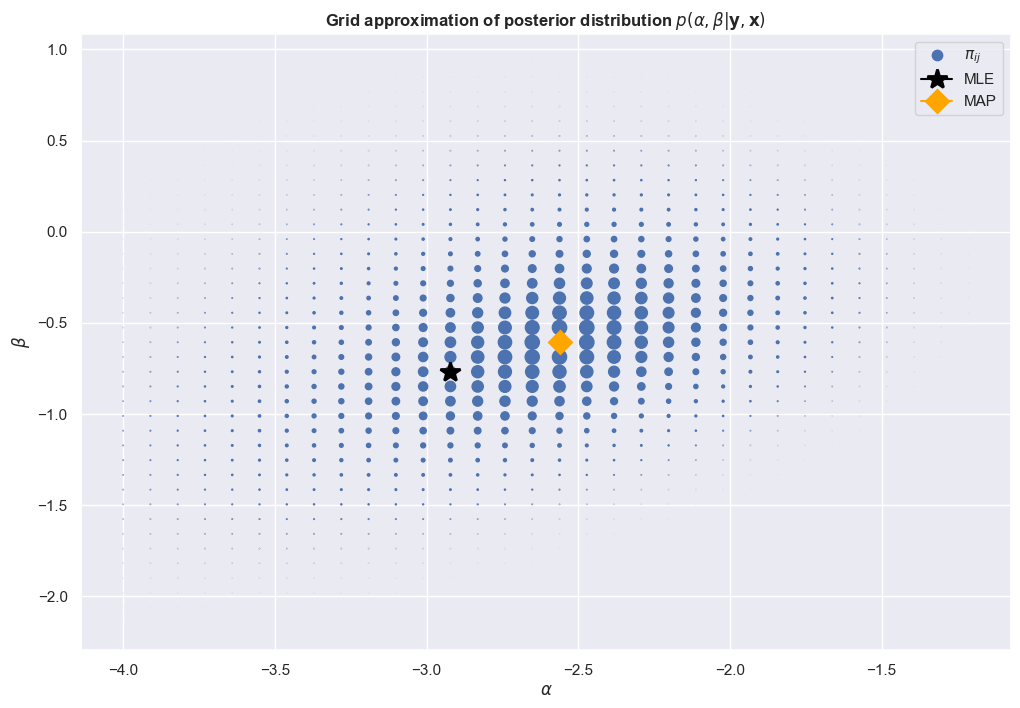

In [ ]:
class GridApproximation2D(Grid2D):
    # This class extends Grid2D to approximate the posterior p(α, β | y, x) using a grid.
    def __init__(self, alphas, betas, log_joint, threshold=1e-8, name="GridApproximation2D"):
        # Initialize Grid2D using alpha, beta grid and the log_joint function.
        Grid2D.__init__(self, alphas, betas, log_joint, name)
        self.threshold = threshold
        # Prepare the grid approximation by normalizing the joint probabilities.
        self.prep_approximation()
        # Compute the marginal distributions for alpha and beta.
        self.compute_marginals()
        # Perform sanity checks on the probability grid.
        self.sanity_check()
        
    def prep_approximation(self):
        """
        Prepares a grid approximation for the posterior distribution.
        Steps:
        1. Shift the log joint grid so that the maximum value becomes 0 (for numerical stability).
        2. Exponentiate the shifted log joint values to obtain unnormalized joint probabilities.
        3. Compute the normalization constant (Z) by summing the unnormalized probabilities.
        4. Normalize the grid so that the probabilities sum to 1.
        5. Flatten the grid arrays for later convenience (e.g., expectation computation, sampling).
        """
        # 1) log_joint_grid is the log of p(y, alpha, beta | x) at each grid point
        # Store the [num_alpha, num_beta]-sized matrix of log joint probabilities.
        self.log_joint_grid = self.values

        # 2) Numerical stability trick: subtract maximum value before exponentiating.
        # Subtract the maximum log probability to improve numerical stability when exponentiating.
        self.log_joint_grid = self.log_joint_grid - jnp.max(self.log_joint_grid)

        # 3) Convert from log-space to real-space probabilities.
        # Exponentiate to obtain the unnormalized joint probabilities: τ_ij = exp(log p(y, α, β))
        self.tilde_probabilities_grid = jnp.exp(self.log_joint_grid)

        # 4) Compute normalization constant (Z) by summing over all grid points.
        # Compute the normalization constant Z by summing over all grid points.
        self.Z = jnp.sum(self.tilde_probabilities_grid)

        # 5) Normalize
        # Normalize the grid: π_ij = τ_ij / Z so that the total probability sums to 1.
        self.probabilities_grid = self.tilde_probabilities_grid / self.Z
        #print(f"Sum of probabilities: {jnp.sum(self.probabilities_grid)}")

        # 6) Flatten for convenience
        print("Shape of Alpha before flattening : ", self.alpha_grid.shape)
        # Flatten the 2D grid of alphas and betas for vectorized operations later.
        self.alphas_flat = self.alpha_grid.flatten()   # shape: [num_alpha * num_beta]
        print("Shape of Alpha flat: ", self.alphas_flat.shape)
        self.betas_flat = self.beta_grid.flatten()       # shape: [num_alpha * num_beta]
        print("Shape of Beta flat: ", self.betas_flat.shape)
        self.num_outcomes = len(self.alphas_flat)        # Total number of grid points
        self.probabilities_flat = self.probabilities_grid.flatten()  # Flattened probability grid

    def compute_marginals(self):
        """
        Computes and stores the marginal distributions over α and β.
        For alpha: sum over beta axis.
        For beta: sum over alpha axis.
        """
        # Compute marginal distribution for α by summing probabilities across all β values for each α.
        self.pi_alpha = jnp.sum(self.probabilities_grid, axis=1) # axis= 1 means summing over the beta axis
        # Compute marginal distribution for β by summing probabilities across all α values for each β.
        self.pi_beta = jnp.sum(self.probabilities_grid, axis=0) # axis= 0 means summing over the alpha axis

    def compute_expectation(self, f):
        """
        Computes the expectation E[f(α, β)] under the grid approximation.
        f: A function that takes vectors of alphas and betas.
        Returns: The expected value obtained by summing f(α, β)*π_ij over the grid.
        """
        return jnp.sum(f(self.alphas_flat, self.betas_flat) * self.probabilities_flat, axis=0)
    
    def sample(self, key, num_samples=1):
        """
        Generates samples from the grid approximation of the posterior.
        key: JAX PRNG key used for sampling.
        num_samples: Number of samples to generate.
        Returns: A tuple (sampled_alphas, sampled_betas)
        """
        # Randomly select indices based on the flattened probability distribution.
        idx = random.choice(key, jnp.arange(self.num_outcomes), p=self.probabilities_flat, shape=(num_samples, 1))
        # Return the corresponding α and β values at the sampled indices.
        return self.alphas_flat[idx], self.betas_flat[idx]

    def visualize(self, ax, scaling=8000, title='Grid approximation'):
        """
        Visualizes the grid approximation on a scatter plot.
        ax: A matplotlib axis object on which to plot.
        scaling: A factor to scale the markers by the probability value.
        title: The title of the plot.
        """
        # Only plot points whose probability exceeds a threshold.
        idx = self.probabilities_flat > self.threshold
        # Create a scatter plot where marker sizes are proportional to the probabilities.
        ax.scatter(self.alphas_flat[idx], self.betas_flat[idx], scaling * self.probabilities_flat[idx], label='$\\pi_{ij}$')        
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(title, fontweight='bold')

    def sanity_check(self):
        """
        Performs basic assertions to ensure that the probability grid:
          - Has the correct shape.
          - Contains no negative values.
          - Sums to 1.
        """
        assert self.probabilities_grid.shape == self.grid_size, \
            "Probability grid does not have shape [num_alphas, num_betas] (self.grid_size). Check your implementation."
        assert jnp.all(self.probabilities_grid >= 0), \
            "Not all values in probability grid are non-negative. Check your implementation."
        assert jnp.allclose(self.probabilities_grid.sum(), 1), \
            "Values in probability grid do not sum to one. Check your implementation."


# Define grid resolution for α and β.
num_alpha, num_beta = 90, 100
alphas = jnp.linspace(-4, 4, num_alpha)
betas = jnp.linspace(-4, 4, num_beta)

# Instantiate the logistic regression model with the given data (x, y, N) and prior variances.
model = LogisticRegression(x, y, N, sigma2_alpha=1.0, sigma2_beta=1.0)

# Construct grid approximation of the posterior using the model's log_joint function.
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')

# Plot the grid approximation
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
post_approx.visualize(ax, title='Grid approximation of posterior distribution $p(\\alpha, \\beta| \\mathbf{y}, \\mathbf{x})$')

# Overlay MLE and MAP estimates on the grid visualization.
ax.plot(alpha_MLE, beta_MLE, 'black', label='MLE', markersize=15, marker='*', markeredgewidth=2)
ax.plot(alpha_MAP, beta_MAP, 'orange', label='MAP', markersize=11, marker='D', markeredgewidth=2)
ax.legend()

If the previous task was implemented correctly, the code about should produce a visualization of the grid approximation. The blue dots show the position of all the grid points, and the radius of the blue dots is controlled by the size of the corresponding weight $\pi_{ij}$. For easier interpretation, we do not plot points where $\pi_{ij}$ is smaller than $10^{-8}$. 


Our first order of business after having obtained the posterior distribution is to produce estimates of the parameters $\alpha$ and $\beta$ as well to quantify the uncertainty, i.e. we will estimate the posterior mean, posterior standard deviation and 95% credibility interval for both $\alpha$ and $\beta$. For this purpose, it is more convenient to work with the marginal posterior distributions of $\alpha$ and $\beta$, which can be readily obtained from the joint posterior approximation $q(\alpha, \beta)$ using the **sum rule**:

$$\begin{align*}
q(\alpha_i) &= \sum_{j} q(\alpha_i, \beta_j) = \sum_{j} \pi_{ij} = \pi^{\alpha}_i\\
q(\beta_j) &= \sum_{i} q(\alpha_i, \beta_j) = \sum_{i} \pi_{ij} = \pi^{\beta}_j,
\end{align*}$$

i.e. $\pi^{\alpha} = q(\alpha_i)$ is the (approximate) marginal posterior probability of $p(\alpha = \alpha_i|\mathbf{y}, \mathbf{x})$.

**Task 4.2**: Go back up the class $\texttt{GridApproximation2D}$ and implemented the $\texttt{compute marginals}$-function. Use it to compute and plot the probability mass functions for the approximate posterior marginal distributions $q(\alpha)$ and $q(\beta)$ as a function of $\alpha$ and $\beta$, respectively.



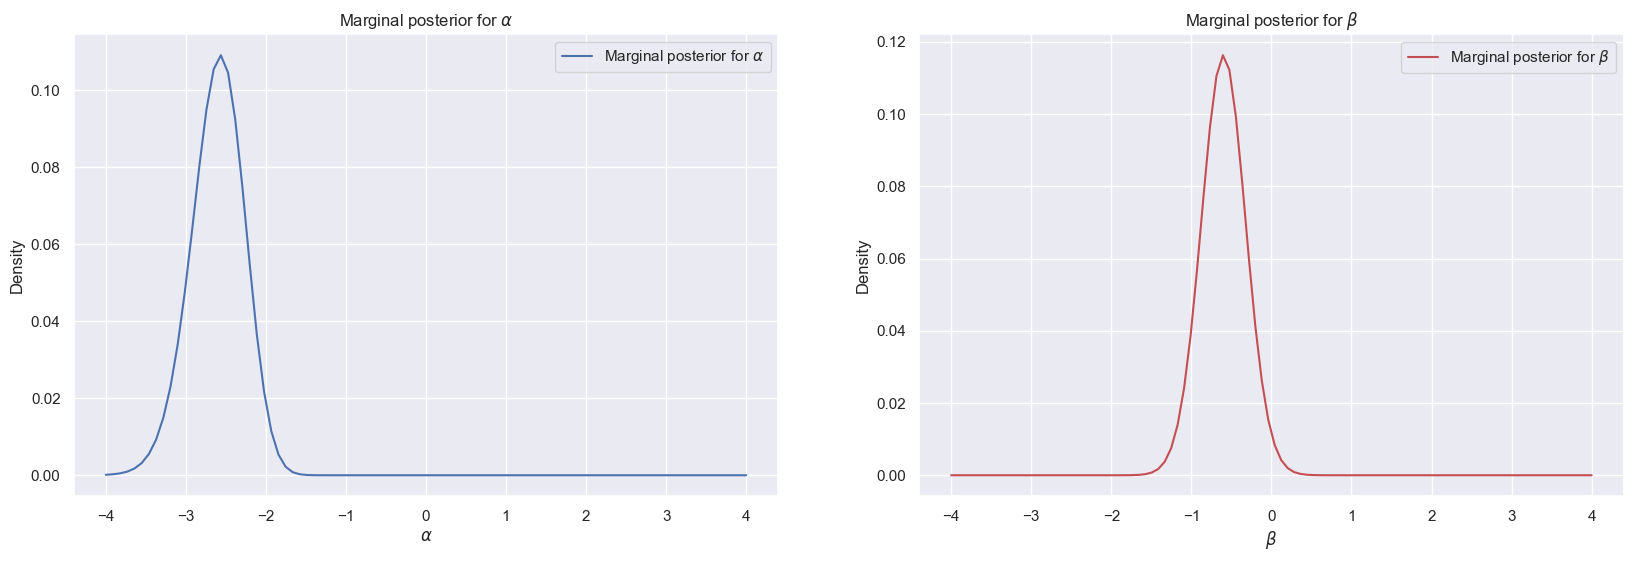

In [77]:
# compute the marginals (this updates the instance attributes)
post_approx.compute_marginals()

marginal_post_alpha = post_approx.pi_alpha
marginal_post_beta = post_approx.pi_beta


fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot the marginal posterior for alpha
ax[0].plot(alphas, marginal_post_alpha, 'b-', label='Marginal posterior for $\\alpha$')
ax[0].set(xlabel='$\\alpha$', ylabel='Density')
ax[0].set_title('Marginal posterior for $\\alpha$')
ax[0].legend()

# Plot the marginal posterior for beta
ax[1].plot(betas, marginal_post_beta, 'r-', label='Marginal posterior for $\\beta$')
ax[1].set(xlabel='$\\beta$', ylabel='Density')
ax[1].set_title('Marginal posterior for $\\beta$')
ax[1].legend()
plt.show()

**Task 4.3**: Compute the posterior mean and standard deviation for $\alpha$ and $\beta$ using the grid approximation by completing the implementation of `DiscreteDistribution1D`-class below. Use the figures from the previous task to verify that your results are (approximately) correct.

*Hints*:
- The mean of a discrete random variable X with PMF $P(X = x)$ is given by $\mathbb{E}\left[X\right] = \sum_{i} x_i P(X = x_i)$, where the sum is over all the possible outcomes of $X$.
- The variance of a discrete random variable X with PMF $P(X = x)$ is given by $\mathbb{V}\left[X\right] = \sum_{i} \left(x_i - \mathbb{E}\left[X\right]\right)^2 P(X = x_i)$, where the sum is over all the possible outcomes of $X$.


_____

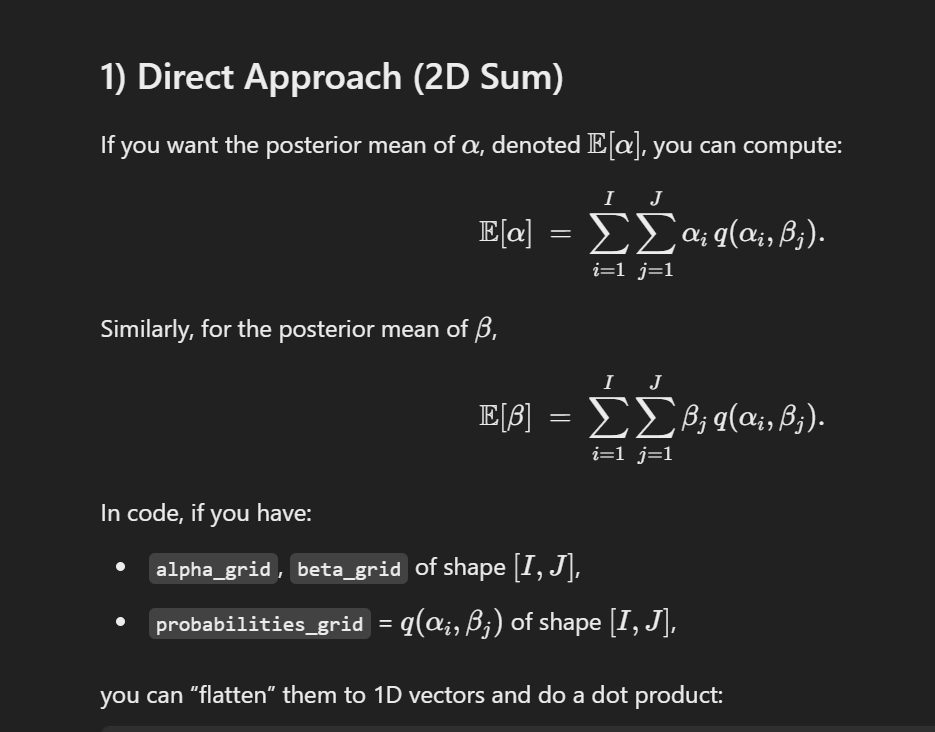
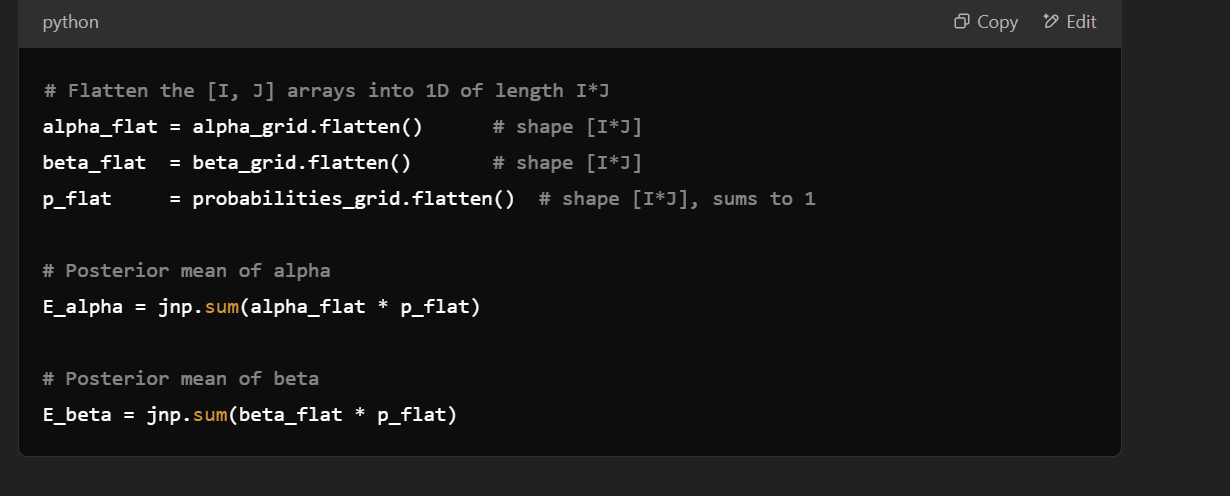
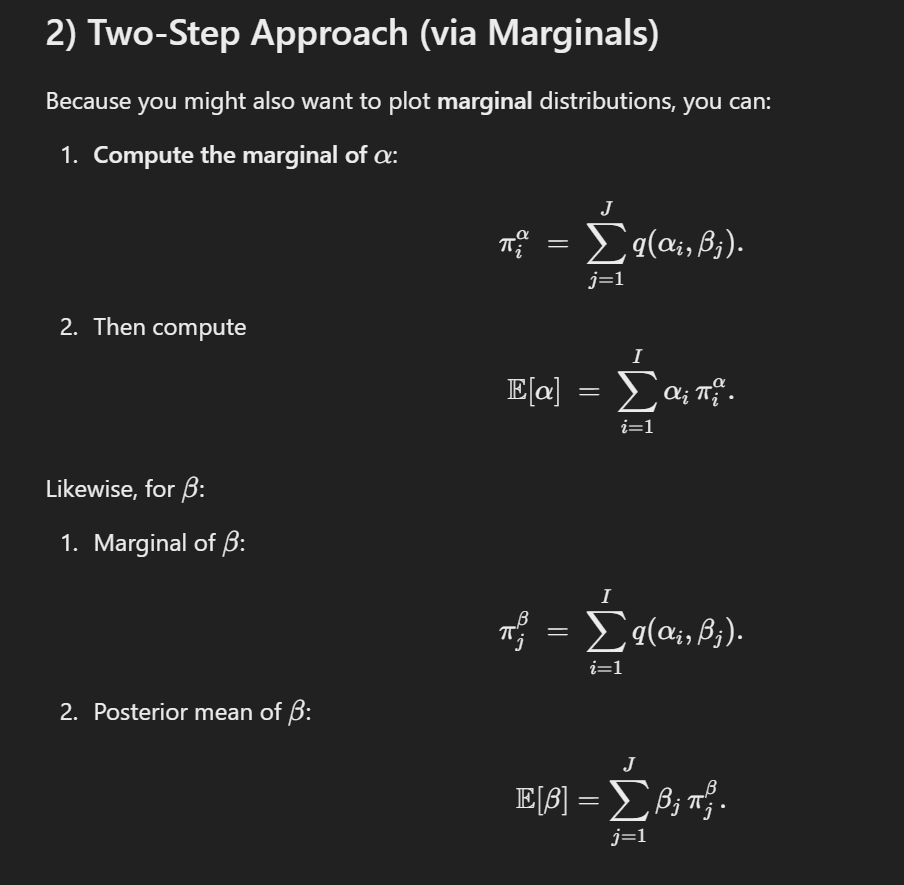

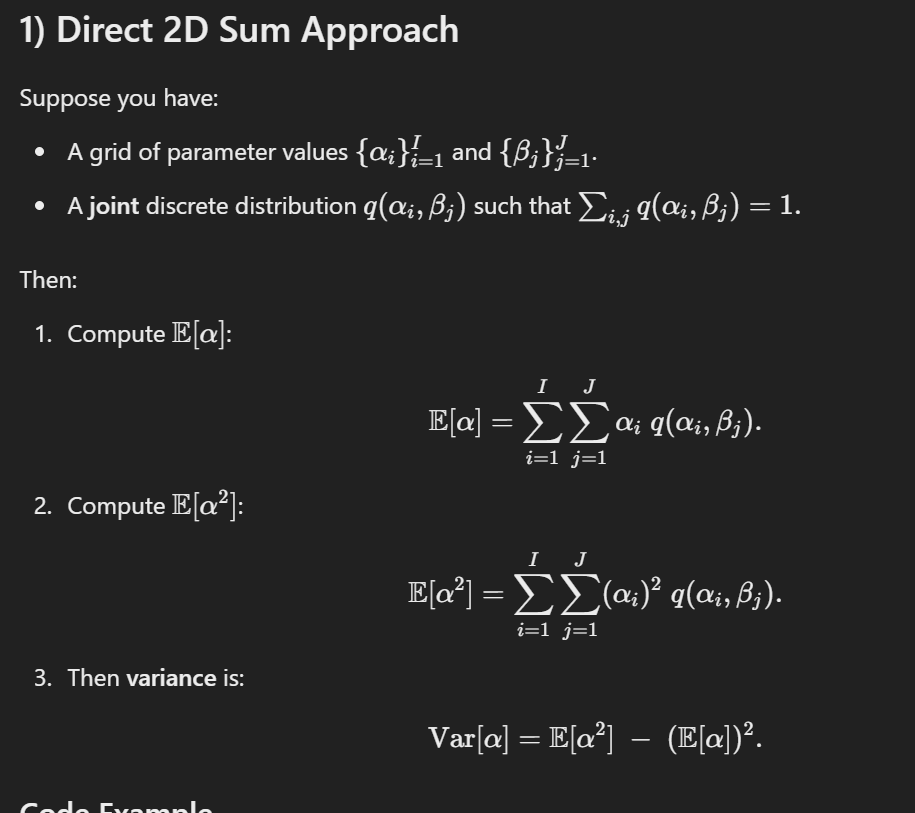
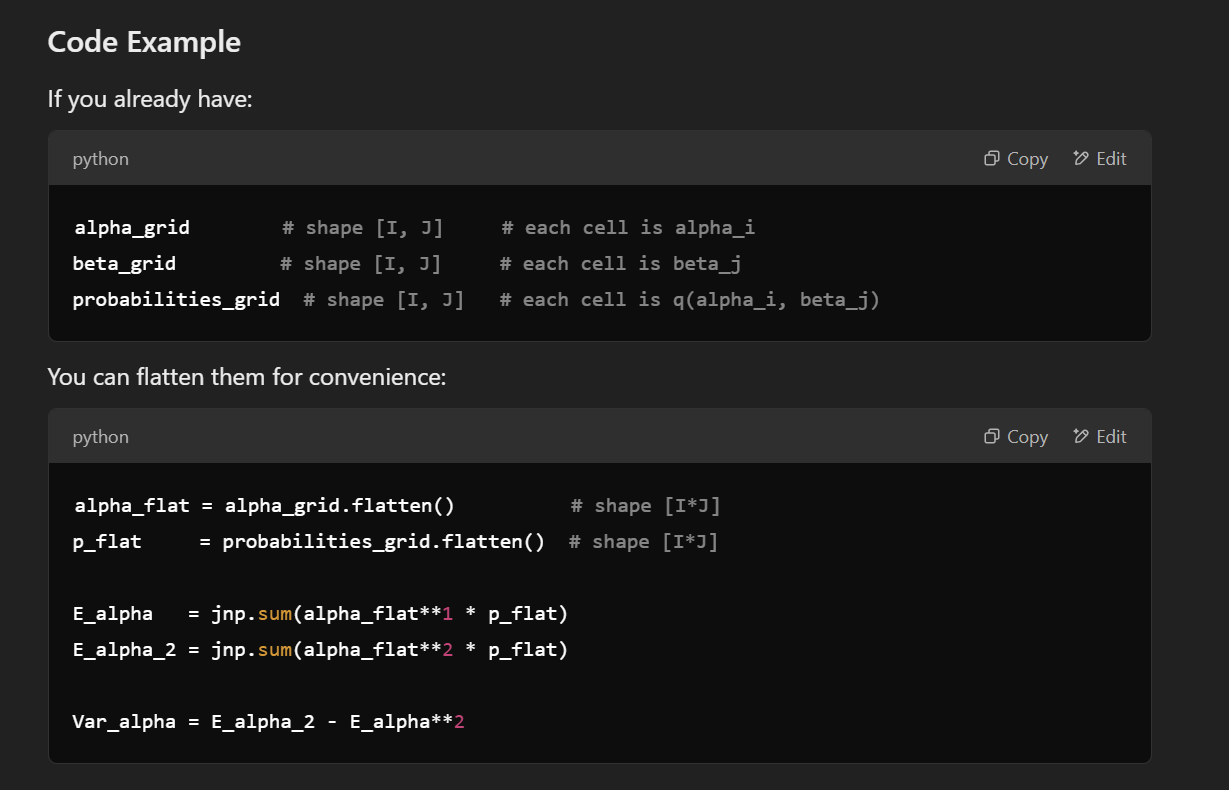

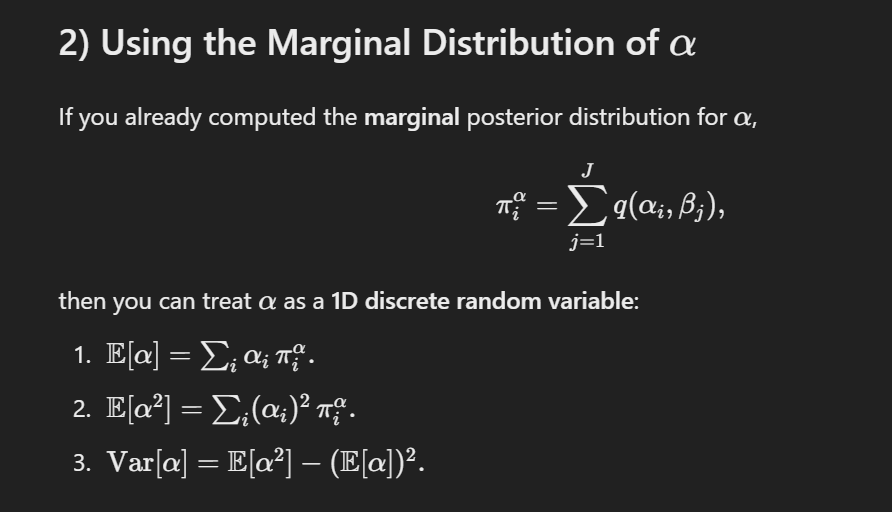
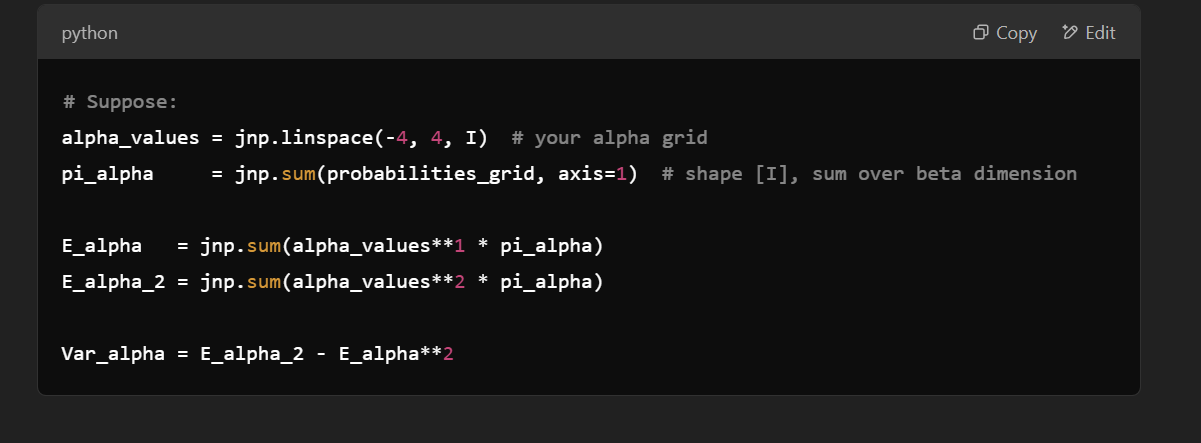


# Compute the posterior mean and standard deviation for alpha and beta.

# 
posterior_mean_alpha = jnp.sum(post_approx.alphas_flat * post_approx.probabilities_flat)

post_mean_alpha_via_marginals = jnp.sum(marginal_post_alpha * alphas)


print("Post mean alpha via grid approximation: ", posterior_mean_alpha)

print("Post mean alpha via marginals: ", post_mean_alpha_via_marginals)

In [ ]:
class DiscreteDistribution1D(object):
    def __init__(self, outcomes, probabilities, name='DiscreteDistribution'):
        """
        Initializes a discrete distribution.
        Inputs:
          outcomes: A 1D array of all possible values the random variable can take.
          probabilities: A 1D array of probabilities corresponding to each outcome.
          name: A string to identify this distribution.
        The constructor asserts the shapes of outcomes and probabilities are identical.
        """
        self.outcomes = outcomes  # Store the array of possible outcomes.
        self.probabilities = probabilities  # Store corresponding probabilities.
        # Ensure that the outcomes and probabilities arrays have the same shape.
        assert self.outcomes.shape == self.probabilities.shape  
        self.name = name  # Set a user-friendly name for this distribution.

    def CDF(self, x):
        """
        Computes the cumulative distribution function (CDF) for a value x.
        It computes P[X <= x] by summing the probabilities for outcomes 
        that are less than or equal to x.
        
        Input:
            x: a threshold value.
        Returns:
            The cumulative probability (a scalar) up to the specified value x.
        """
        # Create an indicator array where outcomes <= x
        idx = self.outcomes <= x  
        # Sum the probabilities for those outcomes and return the result
        return jnp.sum(self.probabilities[idx]) 

    def quantile(self, p):
        """
        Computes the quantile function for the probability p.
        Q(p) is defined as the smallest outcome x such that the CDF at x is at least p.
        
        Input:
            p: probability threshold between 0 and 1.
        Returns:
            The corresponding quantile (or percentile) value.
        """
        # Compute the cumulative sum (CDF values) for the discrete probabilities.
        cdf_values = jnp.cumsum(self.probabilities)
        # Find the indices where the cumulative sum is at least p.
        # Using logical_or checks for p being strictly less than or nearly equal to the CDF values.
        idx = jnp.where(jnp.logical_or(p < cdf_values, jnp.isclose(p, cdf_values)))[0]
        # From the indices found, take the minimum outcome as the desired quantile.
        return jnp.min(self.outcomes[idx])
    
    @property
    def mean(self):
        """
        Computes the mean (expected value) of the discrete distribution.
        Formula: E[X] = sum_(i) [outcome_i * probability_i]
        Returns:
            A scalar representing the expected value.
        """
        return jnp.sum(self.outcomes * self.probabilities)
    
    @property
    def variance(self):
        """
        Computes the variance of the discrete distribution.
        Formula: Var[X] = sum_(i)[ (outcome_i - E[X])^2 * probability_i ]
        Returns:
            A scalar representing the variance.
        """
        # Use the mean computed from the property above.
        return jnp.sum((self.outcomes - self.mean)**2 * self.probabilities)
    
    def central_interval(self, interval_size=95):
        """
        Computes the central credibility (or confidence) interval for this distribution.
        The central interval for an interval_size% credibility is defined as the smallest interval
        [lower, upper] that contains the middle (interval_size)% of the probability.
        
        Input:
            interval_size: the percentage (default 95) for the central interval.
        Returns:
            A jnp.array with two elements: [lower_bound, upper_bound].
        """
        # The total probability left in the tails if interval_size% is in the center.
        c = 1. - interval_size/100.  
        # Lower bound: quantile at p = c/2.
        lower = self.quantile(c/2)
        # Upper bound: quantile at p = 1 - c/2.
        upper = self.quantile(1 - c/2)
        return jnp.array([lower, upper])  
    
    def print_summary(self):
        """
        Prints a summary of key statistics for this discrete distribution.
        It prints the mean, standard deviation (sqrt of variance) and 95% credibility interval.
        """
        print(f'Summary for {self.name}')
        print(f'\tMean:\t\t\t\t{self.mean:3.2f}')
        print(f'\tStd. dev.:\t\t\t{jnp.sqrt(self.variance):3.2f}')
        # Compute and print the central interval.
        print(f'\t95%-credibility interval:\t[{self.central_interval()[0]:3.2f}, {self.central_interval()[1]:3.2f}]\n')


# Example usage and sanity checks using a classic six-sided die:
# Define outcomes for a die: [1, 2, 3, 4, 5, 6]
# All outcomes are equally likely so the probabilities are uniform.
outcomes, probs = jnp.arange(1, 6+1), jnp.ones(6)/6
sixsided_die = DiscreteDistribution1D(outcomes, probs)
# Check that the mean of a fair six-sided die is 3.5
assert jnp.allclose(sixsided_die.mean, 3.5), f"The mean of a six-sided die should be 3.5, but the value was {sixsided_die.mean:3.2f}. Check your implementation."
# Check that the variance is close to 35/12 (~2.92)
assert jnp.allclose(sixsided_die.variance, 35/12), f"The variance of a six-sided die should be approximately 2.92, but the value was {sixsided_die.variance:3.2f}. Check your implementation."
# Check that the 95% central interval of the die spans [1, 6]
assert jnp.allclose(sixsided_die.central_interval(95), jnp.array([1, 6])), f"The (approximate) 95% central interval of a six-sided die should be (1,6), but the value was {sixsided_die.central_interval(95)}. Check your implementation."

#-------------------------------------------------------------------------------

# Summarize posterior marginals for alpha and beta 
# 'post_approx.alphas' and 'post_approx.pi_alpha' come from the grid approximation computed earlier.
# They represent the grid values for the parameter alpha and their marginal probabilities.
post_alpha_marginal = DiscreteDistribution1D(post_approx.alphas, post_approx.pi_alpha, "posterior distribution of alpha")
# Similarly for beta, using the grid values and corresponding marginal probabilities.
post_beta_marginal = DiscreteDistribution1D(post_approx.betas, post_approx.pi_beta, "posterior distribution of beta")

# Print out the summary statistics (mean, std, credibility interval) for the posterior marginal of alpha.
post_alpha_marginal.print_summary()
# Print out the summary statistics for the posterior marginal of beta.
post_beta_marginal.print_summary()


Summary for posterior distribution of alpha
	Mean:				-2.61
	Std. dev.:			0.33
	95%-credibility interval:	[-3.28, -2.02]

Summary for posterior distribution of beta
	Mean:				-0.60
	Std. dev.:			0.28
	95%-credibility interval:	[-1.17, -0.04]



Compare the summary statistics to the plots above. Verify that your results are consistent before moving on.




**Task 4.4**: Compute the prior and posterior probability that $\beta < 0$




In [112]:

################# Prior #############################################################

# Construct grid approximation of the posterior using the model's log_joint function.
prior = GridApproximation2D(alphas, betas, model.log_prior, name='Prior')
prior_approximation = DiscreteDistribution1D(outcomes=prior.betas, probabilities=prior.pi_beta, name="Posterior of betas")

print(f"p(b < 0) = {prior_approximation.CDF(0):.2f}")
print(f"p(b < 0 | y ) = {post_beta_marginal.CDF(0):.2f}")

Shape of Alpha before flattening :  (90, 100)
Shape of Alpha flat:  (9000,)
Shape of Beta flat:  (9000,)
p(b < 0) = 0.50
p(b < 0 | y ) = 0.98


# Part 5:  Propagating uncertainty from parameters to predictions

Using the grid approximation, we got a handle on the posterior distribution of $\alpha$ and $\beta$ given the observed data, i.e. $p(\alpha, \beta|\mathbf{x}, \mathbf{y})$. We will now turn our attention to making predictions. For example, we want to predict the following quantities for a given temperature $t^* \in \mathbb{R}$:

- The probability of failure for each o-ring
- The probability of at least one o-ring failing
- The expected number of failing o-rings
- A 95\%-credibility interval for then number of failed o-rings

**Assuming we know** the value of $\alpha$ and $\beta$, all quantities above are easily computed from the predictive likelihood

$$\begin{align}
p(y^*|x^*, \alpha, \beta) = \text{Bin}(y^*|N^*, \alpha, \beta)
\end{align}
$$

However, in practice we do not now the value of $\alpha$ and $\beta$, and therefore, we need to estimate them. The simplest approach for making predictions is to use a **plugin approximation** like we did in part 3. That is, we simply plug in one of our point estimates for $\alpha$ and $\beta$ into the equation above, e.g. the MLE or MAP estimator. This is usually fast and easy to do, but the significant drawback is that it tends to produce **overconfident** predictions because it ignores the uncertainty for $\theta^*$. Instead, we can propagate the uncertainty from the posterior distribution $q(\alpha, \beta)$ to the predictive distribution using **marginalization** via the sum:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \int \int p(y^*|x^*, \alpha, \beta) p(\alpha, \beta|\mathbf{y}, \mathbf{x}) \text{d}\alpha \text{d}\beta = \mathbb{E}_{p(\alpha, \beta|\mathbf{y}, \mathbf{x})}\left[p(y^*|x^*, \alpha, \beta)\right] \approx \mathbb{E}_{q(\alpha, \beta)}\left[p(y^*|x^*, \alpha, \beta)\right].
\end{align}$

That is, when we make predictions, we average over the posterior distribution. **Instead of picking a single set of parameters, we consider all possible values for $\alpha$ and $\beta$ and weigh them according to their posterior probability**. This may be abstract, but the grid approximation can help understand this more intuitively:

$\begin{align}
p(y^*|\mathbf{y}, \mathbf{x}, x^*) = \mathbb{E}_{p(\alpha, \beta|\mathbf{y})}\left[p(y^*|x^*, \alpha, \beta)\right]\approx \mathbb{E}_{q(\alpha, \beta)}\left[p(y^*|x^*, \alpha, \beta)\right] = \sum_{ij} p(y^*|x^*, \alpha_i, \beta_j) \pi_{ij},
\end{align}
$

where we literally evaluate $p(y^*|x^*, \alpha, \beta)$ for each possible set of parameters $(\alpha_i, \beta_j)$ and weigh them by the posterior probability $\pi_{ij} = q(\alpha_i, \beta_j)$. We refer to the distribution $p(y^*|\mathbf{y}, \mathbf{x}, x^*)$ as the **posterior predictive distribution**. Recall, we can also cast the plugin approximations as approximation over the posterior predictive distribution, where the posterior is approximated by a posterior distribution that as all the mass on the single point $(\hat{\alpha}_{MLE}, \hat{\beta}_{\text{MLE}})$.


The code below uses the plugin approximation for the MLE/MAP estimator to compute and plot the posterior predictive distribution $p(y^*=k|\mathbf{y}, \mathbf{x}, x^*)$ for $k \in \left\lbrace 0, 1, \dots 6\right\rbrace$. The code also reports the mean and a 95\% interval for each methods for each temperatures (assuming the tasks above have been solved). 

**Task 5.1**: Compute and plot and the full posterior predictive distribution $p(y^*=k|\mathbf{y}, \mathbf{x}, x^*)$ with $k \in \left\lbrace 0, 1, \dots 6\right\rbrace$ for $t = 25^{\circ}C$ and $t = 0^{\circ}C$. 



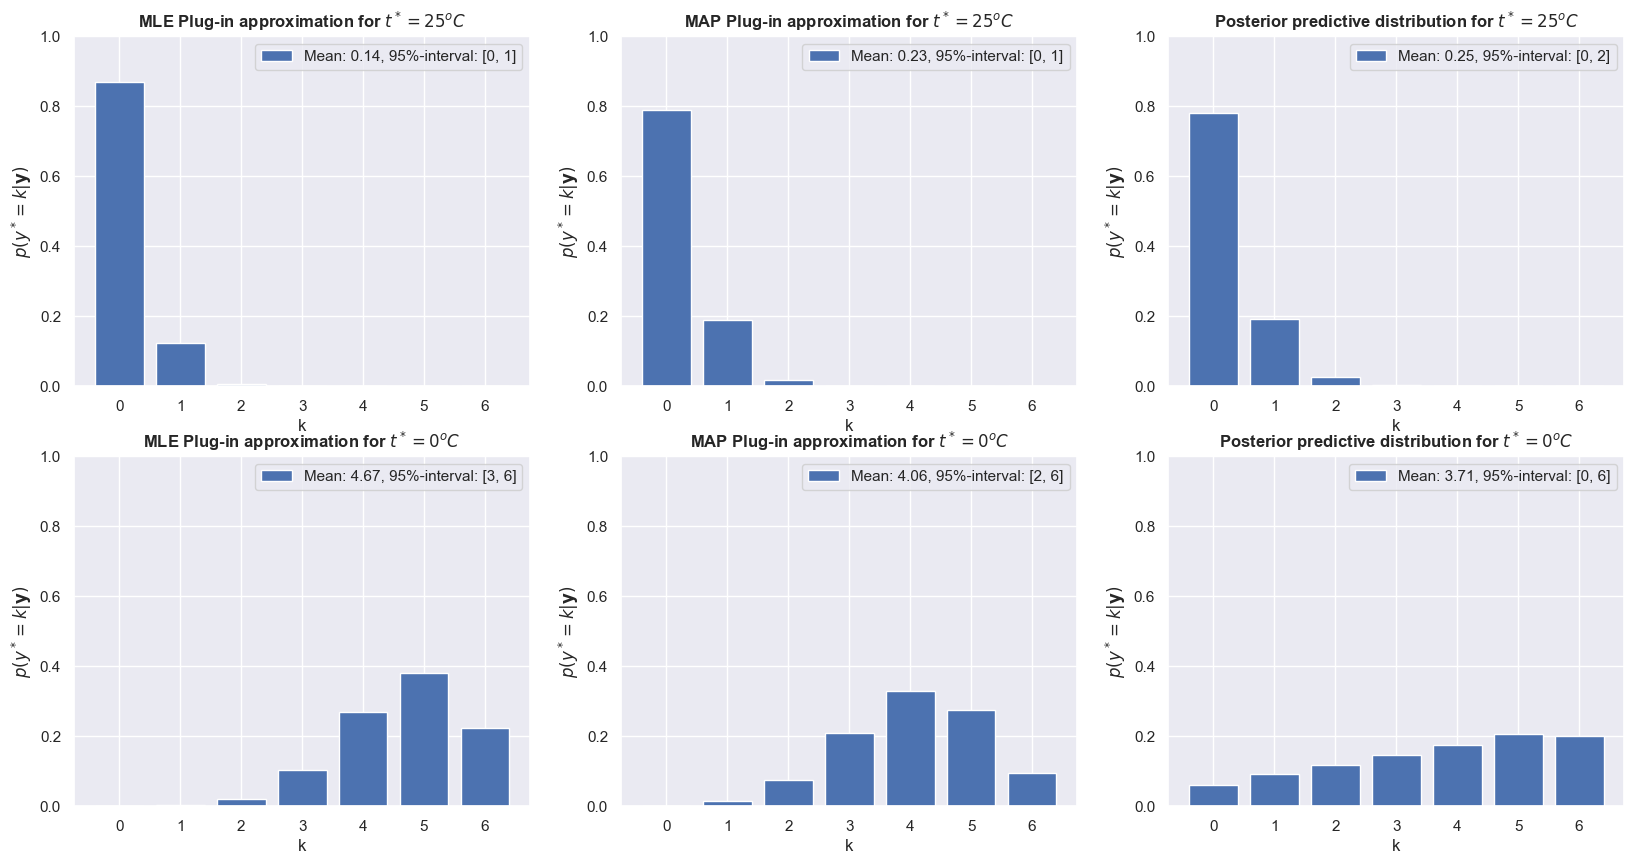

In [116]:
# Define target temperatures for which predictions will be made.
# In this example, we want to compute predictions at t = 25°C and t = 0°C.
temp_stars = [25, 0]

# Define the outcome space for y^*, which represents the possible number of failures.
# Here we assume the number of failures can be 0, 1, 2, ..., 6.
ks = jnp.arange(0, 6+1)

# Define the predictive likelihood function p(y^*=k | x^*, alpha, beta).
# It uses the binomial probability mass function (pmf).
# The function model.theta computes p (the probability of failure) for the standardized input x_star.
# 'binom_dist.pmf' calculates the probability of k failures out of 6 trials.
pred_lik = lambda k, x_star, alpha, beta: binom_dist.pmf(k=k, n=6, p=model.theta(x_star, alpha, beta))

# Create a figure with a grid of subplots.
# There will be 2 rows (one for each temperature) and 3 columns (one for each prediction method).
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Define a lambda function that formats a string with the distribution's mean and its 95% credibility interval.
# This label will be used in the legend of the plots.
mean_and_interval_label = lambda dist: f'Mean: {dist.mean:3.2f}, 95%-interval: [{dist.central_interval()[0]:d}, {dist.central_interval()[1]:d}]'

# Loop over each target temperature along with an index.
for n, t_star in enumerate(temp_stars):

    # Standardize the temperature to obtain x^*. The function 'standardize' is assumed to
    # use the provided tmean and tstd to convert the temperature into the model's input scale.
    x_star = standardize(t_star)

    # Compute the predictive likelihood probabilities using the plug-in MLE estimator.
    # This evaluates the predictive likelihood at all outcome points (ks) for x_star using alpha_MLE and beta_MLE.
    pred_lik_probs_MLE = pred_lik(ks, x_star, alpha_MLE, beta_MLE)
    
    # Compute the predictive likelihood probabilities using the plug-in MAP estimator.
    # This evaluates the predictive likelihood at all outcome points (ks) for x_star using alpha_MAP and beta_MAP.
    pred_lik_probs_MAP = pred_lik(ks, x_star, alpha_MAP, beta_MAP)
    
    # Compute the posterior predictive distribution by averaging over all parameter values,
    # weighted by their posterior probability. The resulting probabilities should be an array of shape [7]
    # so that each element corresponds to the probability of k failures. 
    # Here the code is not yet filled in and uses a placeholder.
    pred_lik_bayes_probs = jnp.sum(jnp.multiply(post_approx.probabilities_grid[:, :, None], pred_lik(ks, x_star, post_approx.alpha_grid[:, :, None], post_approx.beta_grid[:, :, None])), axis=(0, 1))


    # Prepare discrete distributions for plotting.
    # Create a DiscreteDistribution1D instance for the plug-in MLE predictions.
    pred_dist_MLE = DiscreteDistribution1D(ks, pred_lik_probs_MLE, name='MLE Plug-in approximation')
    # Create a DiscreteDistribution1D instance for the plug-in MAP predictions.
    pred_dist_MAP = DiscreteDistribution1D(ks, pred_lik_probs_MAP, name='MAP Plug-in approximation')
    # Create a DiscreteDistribution1D instance for the full Bayesian (posterior predictive) predictions.
    pred_dist_bayes = DiscreteDistribution1D(ks, pred_lik_bayes_probs, name="Posterior predictive distribution")

    # For each prediction method, create a bar plot on the corresponding subplot.
    # The plots display the probabilities for each outcome in ks.
    for i, dist in enumerate([pred_dist_MLE, pred_dist_MAP, pred_dist_bayes]):
        # Create a bar plot: x-axis is the outcome (k) and y-axis is the probability.
        # The label includes the mean and 95% credibility interval for the distribution.
        ax[n, i].bar(ks, dist.probabilities, label=mean_and_interval_label(dist))
        # Set the axis labels and limits for visual consistency.
        ax[n, i].set(xlabel='k', ylabel='$p(y^* = k|\\mathbf{y})$', ylim=(0, 1))
        # Set the title indicating which prediction method is used and for which temperature.
        ax[n, i].set_title(f'{dist.name} for $t^* = {t_star}^oC$', fontweight='bold')
        # Add legend to the plot to display distribution summary.
        ax[n, i].legend()


**Task 5.2**: Comment on the differences between the results obtained using plugin approximations, i.e. the MLE/MAP estimators, and the posterior predictive distributions. How does the three approximations compare? In regions with data? In regions without data?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*



In the very last of the exercise, we will visualize the posterior for $f(x)$ and $\theta(x)$ to build over intuition. We will start by drawing a set of random samples of $(\alpha, \beta)$ from the posterior approximation and then compute and visualize $f(x)$ and $\theta(x)$ for each sample. We will repeat this process for the prior distribution $p(\alpha, \beta)$.

**Task 5.3**: The code below generates $\texttt{num samples}$ of $\alpha, \beta$ from both the prior and posterior and plots them. Compute $f(x_{\text{pred}})$ and $\theta(x_{\text{pred}})$ for each of these samples and store them in the variables $\texttt{f samples}$ and $\texttt{theta samples}$ pre-defined below. 

Shape of Alpha before flattening :  (90, 100)
Shape of Alpha flat:  (9000,)
Shape of Beta flat:  (9000,)
Shape of Alpha before flattening :  (90, 100)
Shape of Alpha flat:  (9000,)
Shape of Beta flat:  (9000,)


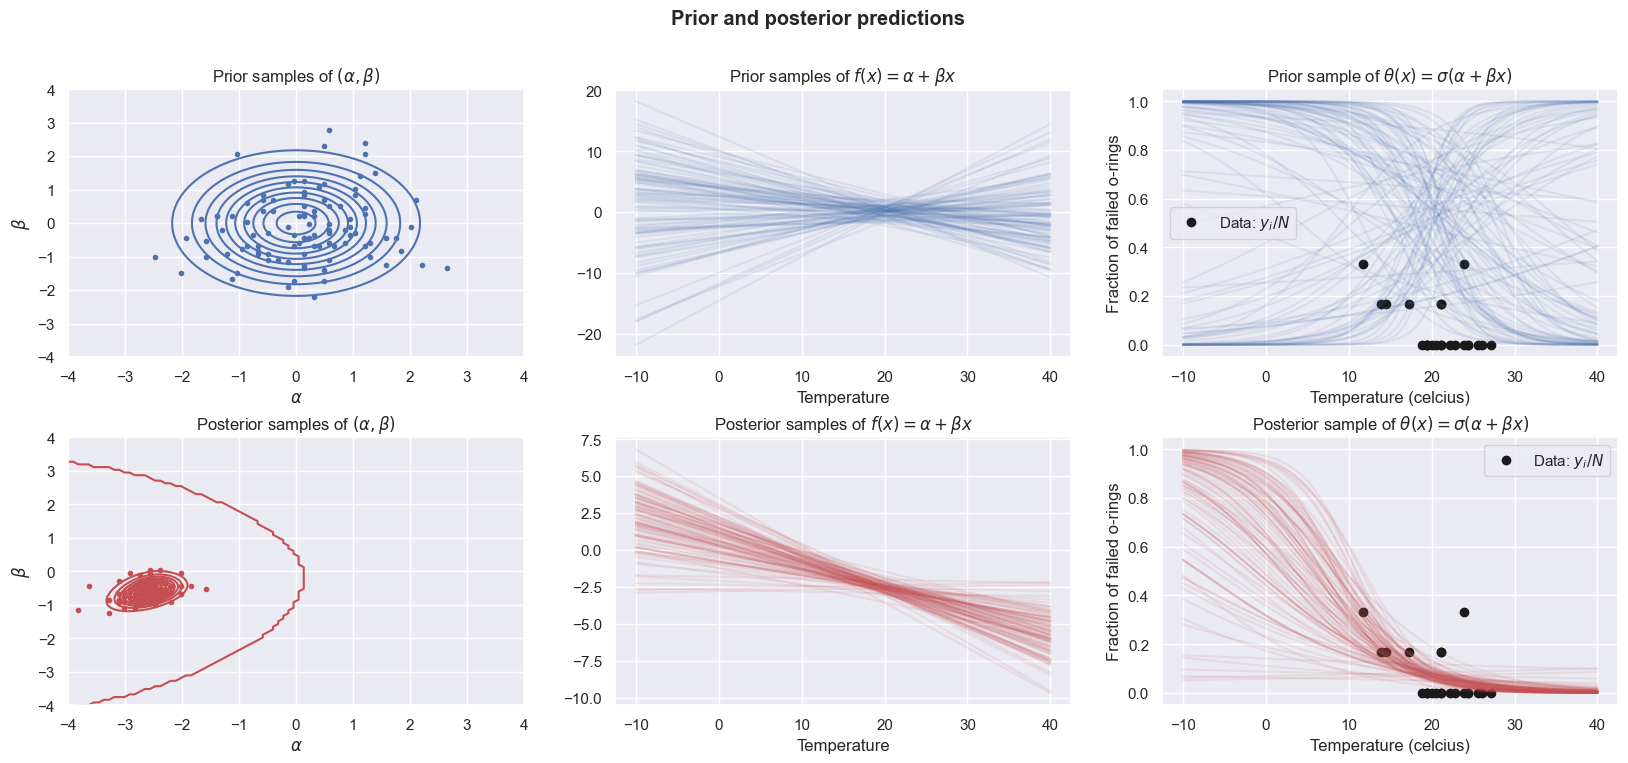

In [ ]:
# Data for predictions:
# Generate a set of temperature points (in Celsius) for which we want to compute predictions.
temp_pred = jnp.linspace(-10, 40, 500)
# Standardize the temperatures using the model's standardization (tmean and tstd are already defined)
x_pred = standardize(temp_pred)
# Total number of o-ring trials for each temperature prediction
N_pred = 6

# Number of samples for visualization from the prior and posterior distributions.
num_samples = 100

# Set up a grid for the alpha and beta parameters.
# num_alpha and num_beta determine the resolution of the grid.
num_alpha, num_beta = 90, 100
# Create a linearly spaced grid for alpha parameter values
alphas = jnp.linspace(-4, 4, num_alpha)
# Create a linearly spaced grid for beta parameter values
betas = jnp.linspace(-4, 4, num_beta)

# Set up the logistic regression model using the observed data (x, y) and the number of trials N.
# sigma2_alpha and sigma2_beta are the prior variances for alpha and beta.
model = LogisticRegression(x, y, N, sigma2_alpha=1., sigma2_beta=1.)

# Use a grid approximation to obtain the (approximate) posterior distribution of (alpha, beta)
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')
# Similarly, obtain the grid approximation for the prior distribution
prior_approx = GridApproximation2D(alphas, betas, model.log_prior, name='Prior')

# Specify a seed for reproducibility and create a random key for sampling.
seed = 123
key = random.PRNGKey(seed)

# Create a figure with 2 rows and 3 columns of subplots.
# Each row corresponds to a distribution (first row for prior, second row for posterior)
# The columns: 0 - grid contour and sample scatter, 1 - f(x) samples, 2 - theta(x) samples.
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

# Loop through the distributions (prior and posterior) for visualization.
for idx_plot, dist in enumerate([prior_approx, post_approx]):
    # Split the random key to get a new subkey for sampling without altering the original key.
    key, subkey = random.split(key)

    # Plot the observed data and contours of the current (prior or posterior) distribution.
    # The third subplot in the current row (ax[idx_plot, 2]) will show the data.
    plot_data(ax[idx_plot, 2], counts=False)
    # Plot probability contours (after applying exponential to convert from log probabilities)
    # 'color' is picked from the colors list using the current index.
    dist.plot_contours(ax[idx_plot, 0], f=jnp.exp, color=colors[idx_plot])

    # Get samples of the parameters (alpha, beta) from the current distribution.
    # These samples will be used to visualize the uncertainty.
    alpha_samples, beta_samples = dist.sample(subkey, num_samples)

    # Compute the samples for f(x_pred) and theta(x_pred) using the current parameter samples.
    # f(x) is typically the linear function: alpha + beta * x, and theta(x) is the probability (via sigmoid).
    # The shape will be (num_samples, len(temp_pred)) to enable plotting multiple uncertainty curves.
    f_samples = model.f(x_pred, alpha_samples, beta_samples)
    theta_samples = model.theta(x_pred, alpha_samples, beta_samples)

    # Overlap the (alpha, beta) scatter plot on the contour plot in the first column.
    ax[idx_plot, 0].plot(alpha_samples, beta_samples, '.', color=colors[idx_plot])

    # Plot each sample's f(x) on the second subplot.
    # Transpose the samples so that each curve is drawn along temp_pred.
    ax[idx_plot, 1].plot(temp_pred, f_samples.T, '', color=colors[idx_plot], alpha=0.1)
    # Plot each sample's theta(x) on the third subplot.
    ax[idx_plot, 2].plot(temp_pred, theta_samples.T, '', color=colors[idx_plot], alpha=0.1)
    # Add a legend for the theta(x) plot.
    ax[idx_plot, 2].legend()

    # Set titles and labels for clarity.
    ax[idx_plot, 0].set(title=f'{dist.name} samples of $(\\alpha, \\beta)$')
    ax[idx_plot, 1].set(title=f'{dist.name} samples of $f(x) = \\alpha + \\beta x$', xlabel='Temperature')
    ax[idx_plot, 2].set(title=f'{dist.name} samples of $\\theta(x) = \\sigma(\\alpha + \\beta x)$')

# Set a global title for the entire figure.
fig.suptitle('Prior and posterior predictions', fontweight='bold')
# Adjust vertical spacing between subplots for improved layout.
fig.subplots_adjust(hspace=0.3)


**Task 5.4**: Study the code and plots above and make sure you can explain the following:

- What is plotted in each of the six panels? 
- What is the relationship between each of the dots in the left columns and the curves in the center and right columns?
- How the uncertainty on $f(x)$ and $\theta(x)$ is controlled by the distribution of $(\alpha, \beta)$?
- How well does each of the prior samples match the observed data?
- How well does each of the posterior samples match the observed data?



We can also use posterior samples to the summarize the pointwise posterior mean and 95\% intervals of $f(x)$ and $\theta(x)$ :

Shape of Alpha before flattening :  (90, 100)
Shape of Alpha flat:  (9000,)
Shape of Beta flat:  (9000,)
Shape of Alpha before flattening :  (90, 100)
Shape of Alpha flat:  (9000,)
Shape of Beta flat:  (9000,)


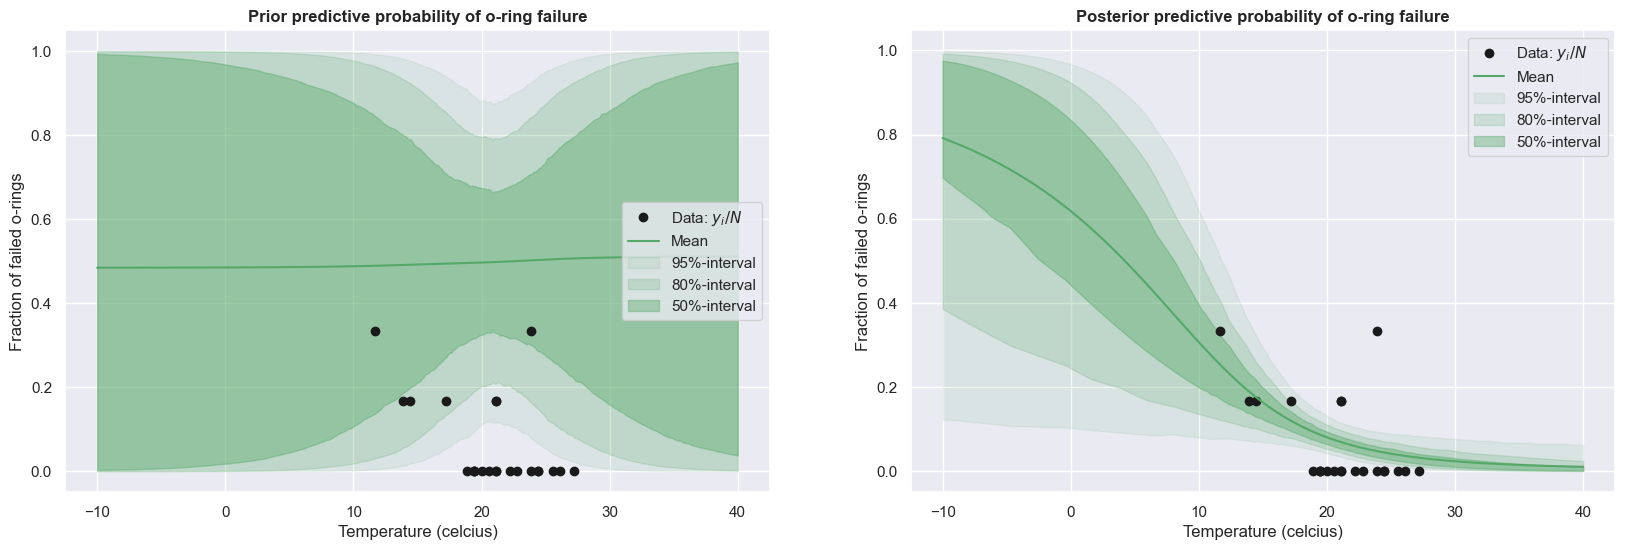

In [ ]:
# Set a random seed for reproducibility and create a random key.
seed = 0
key = random.PRNGKey(seed)

# Set up the logistic regression model using the observed data,
# and specify the prior variances for alpha and beta.
model = LogisticRegression(x, y, N, sigma2_alpha=1., sigma2_beta=1.)

# Create grid approximations for the posterior and the prior distributions.
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')
prior_approx = GridApproximation2D(alphas, betas, model.log_prior, name='Prior')

# Set up a figure with 1 row and 2 columns to plot prior and posterior results side by side.
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot the observed data on both subplots.
plot_data(ax[0], counts=False)
plot_data(ax[1], counts=False)

# Number of samples to draw from each distribution for visualization.
num_samples = 2000

# Loop over the two distributions (prior and posterior) and get samples.
for idx_plot, dist in enumerate([prior_approx, post_approx]):
    # Split the random key for sampling.
    key, subkey = random.split(key)
    
    # Sample alpha and beta parameters from the current distribution.
    alpha_samples, beta_samples = dist.sample(subkey, num_samples)
    
    # Compute the predicted failure probability 'theta' for each temperature in x_pred,
    # using the obtained alpha and beta samples.
    theta_samples = model.theta(x_pred, alpha_samples, beta_samples)
    
    # Compute the mean predicted probability at each prediction temperature.
    theta_mean = theta_samples.mean(0)
    
    # Compute the lower and upper quantiles (2.5% and 97.5%) for theta.
    theta_lower = jnp.quantile(theta_samples, 0.025, axis=0)
    theta_upper = jnp.quantile(theta_samples, 0.975, axis=0)

    # Plot the mean predicted probability as a green line.
    ax[idx_plot].plot(temp_pred, theta_mean, 'g-', label='Mean')
    
    # Plot various credibility intervals by filling between the computed quantiles.
    # Three intervals are plotted: 95%, 80%, and 50%.
    for interval_size, alpha_level in [(0.95, 0.1), (0.8, 0.2), (0.5, 0.4)]:
        # Compute the tail probability.
        tail_prob = 1 - interval_size
        # Compute the lower quantile for the current interval.
        theta_lower = jnp.quantile(theta_samples, tail_prob / 2, axis=0)
        # Compute the upper quantile for the current interval.
        theta_upper = jnp.quantile(theta_samples, 1 - tail_prob / 2, axis=0)
        # Fill the area between the lower and upper quantiles with green color and set transparency.
        ax[idx_plot].fill_between(temp_pred, theta_lower, theta_upper, color='g', alpha=alpha_level, label=f'{interval_size*100:2.0f}%-interval')
    
    # Add legend and title for the current subplot.
    ax[idx_plot].legend()
    ax[idx_plot].set_title(f'{dist.name} predictive probability of o-ring failure', fontweight='bold')

**Task 5.5**: Compute and plot the posterior mean and a 95% credibility interval for the probability of obtaining at least one failure among the 6 o-rings



In [121]:
# posterior mean 

post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')
post_alpha_marginal = DiscreteDistribution1D(post_approx.alphas, post_approx.pi_alpha, "posterior distribution of alpha")
post_beta_marginal = DiscreteDistribution1D(post_approx.betas, post_approx.pi_beta, "posterior distribution of beta")


# probability for obtaining at least one failure 
p_failure = 1 - post_approx.probabilities_grid[0, 0]
print(f"p(failure) = {p_failure:.2f}")



Shape of Alpha before flattening :  (90, 100)
Shape of Alpha flat:  (9000,)
Shape of Beta flat:  (9000,)
p(failure) = 1.00
